In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
import graph_tool.all as gt

In [2]:
sns.set_context("talk")

In [3]:
ver = 447
fdir = "~/seungmount/research/runzhey/datasets/FlyWire/{}/syn_proof_analysis_{}.feather".format(ver, ver)
syn_table = pd.read_feather(fdir)

In [4]:
def vis_link(segs, mode='single'):
    if mode == 'single':
        with open("./saved/ng_templates/single_module_view.txt") as f:
            ng_tmp = f.read()
        return ng_tmp.format("%22%2C%22".join([str(seg) for seg in segs]))
    elif mode == 'double':
        with open("./saved/ng_templates/two_module_view.txt") as f:
            ng_tmp = f.read()
        return ng_tmp.format("%22%2C%22".join([str(seg) for seg in segs[0]]),
                             "%22%2C%22".join([str(seg) for seg in segs[1]]))
    return None

### 1. Graph Construction

In [5]:
# build index dictionary
cellids =  np.unique(syn_table[["pre_pt_root_id", "post_pt_root_id"]])
nid2cid = {i: cid for i, cid in enumerate(cellids)}
cid2nid = {cid: i for i, cid in enumerate(cellids)}

In [6]:
syn_table["pre_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["pre_pt_root_id"]], 
                                 index=syn_table.index)
syn_table["post_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["post_pt_root_id"]], 
                                 index=syn_table.index)

In [7]:
merged_syn_table = syn_table[["pre_nid", "post_nid", "syn_count"]
                           ].groupby(by=["pre_nid", "post_nid"]).sum().reset_index()

In [8]:
merged_edge_list = [(e[0], e[1], e[2]) for e in merged_syn_table.values]

In [9]:
g = gt.Graph()
g.add_vertex(len(cellids))
e_syn_count = g.new_ep("int32_t")
g.add_edge_list(merged_edge_list, eprops=[e_syn_count])
g.vp["cellid"] = g.new_vp("int64_t")
g.vp["cellid"].a = cellids
g.ep["syn_count"] = e_syn_count

In [10]:
strong_filter = g.new_ep('bool')
for e in g.edges():
    strong_filter[e] = True if g.ep["syn_count"][e] >=5 else False
g.set_edge_filter(strong_filter)
g = gt.Graph(g, prune=True)

In [11]:
# merged weightedd graph
g

<Graph object, directed, with 68586 vertices and 1543342 edges, 1 internal vertex property, 1 internal edge property, at 0x7fcd6e112128>

### 2. Graph Spectra of FlyWire

In [12]:
wcc_g = gt.extract_largest_component(g, directed=False)
wcc_g

<GraphView object, directed, with 67138 vertices and 1543330 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fcd6e112358, at 0x7fcd906fd320>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fcd6e112358, at 0x7fcd6e112cc0>, False), at 0x7fcd6e112358>

In [13]:
scc_g = gt.extract_largest_component(g, directed=True)
scc_g

<GraphView object, directed, with 61709 vertices and 1504956 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fcc334312e8, at 0x7fcc334316d8>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fcc334312e8, at 0x7fcc33431668>, False), at 0x7fcc334312e8>

In [14]:
# sparse adjacency matrix of the largest 
# weakly connected component of g
# Aij indicate connection j->i
A_w = gt.adjacency(wcc_g)

In [15]:
A_w

<67138x67138 sparse matrix of type '<class 'numpy.float64'>'
	with 1543330 stored elements in Compressed Sparse Row format>

In [16]:
# sparse adjacency matrix of the largest 
# strongly connected component of g
# Aij indicate connection j->i
A_s = gt.adjacency(scc_g)

In [17]:
A_s

<61709x61709 sparse matrix of type '<class 'numpy.float64'>'
	with 1504956 stored elements in Compressed Sparse Row format>

#### 2.1 Chung's Laplacian for directed graphs

Given a graph $G(V,E)$ and its weighted adjacency matrix $A\in \mathbb R^{n\times n}_{\geq 0}$,  where  $A_{ij}$ indicates the number of connections (or synapses) from neuron $j$ to neuron $i$ , one can construct a Markov chain on the graph with a transition matrix $P_{\alpha}$, such that $[P_\alpha]_{ij} := (1-\alpha)\cdot A_{ij}/\sum_{k}A_{kj} + \alpha/n$. The small coefficient $\alpha > 0$ ensures that the constructed Markov chain is irreducible, and Perron-Frobenius theorem guarantees $P_\alpha$ has a unique positive right eigenvector $\vec \pi$ with eigenvalue 1. $ \vec \pi$ is also called a stationary distribution. The normalized symmetric Laplacian of the Markov chain is
$$\mathcal L = I -\frac{1}{2}\left(\Pi^{-1/2}P_{\alpha}\Pi^{1/2} + \Pi^{1/2}P_{\alpha}^{\intercal}\Pi^{-1/2}\right),$$
where $\Pi := {\tt diag}(\vec \pi)$, and $I$ is the identity matrix. We can verify that $\mathcal L$ is symmetric and positive semi-definite.

To prevent large dense matrix for resolving the irreducibility issue of the walk, we restricted our analysis to the largest SCC of `g`, which contains 99% neurons. And we add the laziness to make sure the walk is aperiodic, i.e.
$$P = \frac{1}{2}I + \frac{1}{2}AD_{-}^{-1}$$
where $[D_{-}]_{ij} = \delta_{ij}\sum_{k}A_{kj}$ is the out-degree matrix.  
It's also interesting to investigate the reversed walk
$$P^{rev} = \frac{1}{2}I + \frac{1}{2}A^{\intercal}D_{+}^{-1}$$
where $[D_{+}]_{ij} = \delta_{ij}\sum_{k}A_{ik}$ is the in-degree matrix.

In [18]:
def _transition_matrix(M):
    
    from scipy.sparse import identity, spdiags
    
    n, m = M.shape
    DI = spdiags(1.0 / np.array(M.sum(axis=0).flat), [0], n, n)
    # add laziness to the walk
    I = identity(n)
    P = (I + M@DI) / 2.0

    return P

def sparse_directed_laplacian_matrix(M):
    
    from scipy.sparse import spdiags, linalg, identity
    P = _transition_matrix(M)
    n, m = P.shape
    
    # get stationary distribution
    evals, evecs = linalg.eigs(P, k=1)
    v = evecs.flatten().real
    p = v / v.sum()
    sqrtp = np.sqrt(p)
    Q = spdiags(sqrtp, [0], n, n) @ P.T @ spdiags(1.0 / sqrtp, [0], n, n)
    I = identity(n)
    
    # returns staitonary distribution and p
    return I - (Q + Q.T) / 2.0, p

In [19]:
L_chung, p_stationary = sparse_directed_laplacian_matrix(A_s)
L_chung_rev, p_stationary_rev = sparse_directed_laplacian_matrix(A_s.T)

In [20]:
scc_g.num_vertices()/ 8000

7.713625

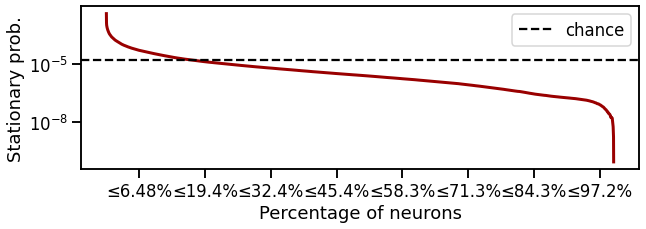

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(np.sort(p_stationary)[::-1], linewidth=3, color=(0.6,0,0))
ax.axhline(1/scc_g.num_vertices(), linestyle='--', color='k', label='chance')
ax.set_yscale('log')
ax.set_xticks(np.arange(4000, scc_g.num_vertices(), 8000))
ax.set_xticklabels(["≤{:.3}%".format(100*i) for i in (np.arange(4000, scc_g.num_vertices(), 8000)+1)/scc_g.num_vertices()])
ax.legend()
ax.set_ylabel("Stationary prob.")
ax.set_xlabel("Percentage of neurons")
plt.show()

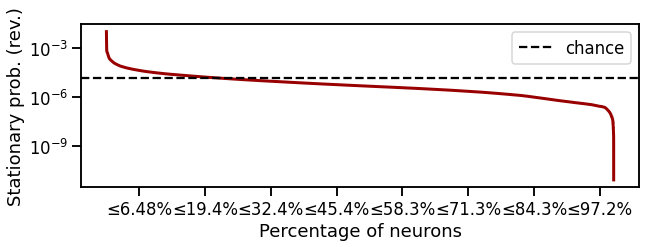

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(np.sort(p_stationary_rev)[::-1], linewidth=3, color=(0.6,0,0))
ax.axhline(1/scc_g.num_vertices(), linestyle='--', color='k', label='chance')
ax.set_yscale('log')
ax.set_xticks(np.arange(4000, scc_g.num_vertices(), 8000))
ax.set_xticklabels(["≤{:.3}%".format(100*i) for i in (np.arange(4000, scc_g.num_vertices(), 8000)+1)/scc_g.num_vertices()])
ax.legend()
ax.set_ylabel("Stationary prob. (rev.)")
ax.set_xlabel("Percentage of neurons")
plt.show()

In [23]:
# top 10 most visited neurons, in the forward MC
top10visited = [nid2cid[n] for n in scc_g.get_vertices()[np.argsort(p_stationary)[::-1][:10]]]
top10visited

[720575940643589832,
 720575940606564482,
 720575940608188427,
 720575940611892453,
 720575940622525901,
 720575940646449716,
 720575940624606136,
 720575940628773223,
 720575940632962786,
 720575940636034661]

In [24]:
1/scc_g.num_vertices()

1.6205091639793222e-05

In [25]:
np.sort(p_stationary)[::-1][:10]

array([0.00393582, 0.00206005, 0.00200857, 0.00200609, 0.00177834,
       0.00177653, 0.001703  , 0.00165469, 0.00153104, 0.00150151])

In [26]:
np.sort(p_stationary)[::-1][:10] / (1/scc_g.num_vertices())

array([242.87532208, 127.12363952, 123.94677645, 123.79374078,
       109.73963964, 109.62808769, 105.09034087, 102.10914066,
        94.4791353 ,  92.65656415])

In [27]:
inspect_cid = top10visited[0]

Text(0.5, 0, 'out regions of 720575940643589832')

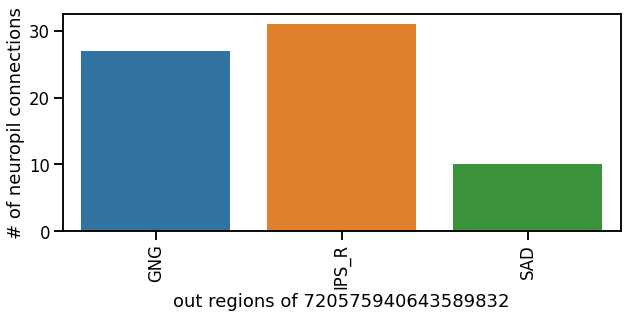

In [28]:
out_regions, out_counts = np.unique(syn_table[syn_table["pre_pt_root_id"] == inspect_cid]["neuropil"], return_counts=True)
fig, ax = plt.subplots(1,1,figsize=(10,4))
sns.barplot(out_regions, out_counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("out regions of {}".format(inspect_cid))

Text(0.5, 0, 'In regions of 720575940643589832')

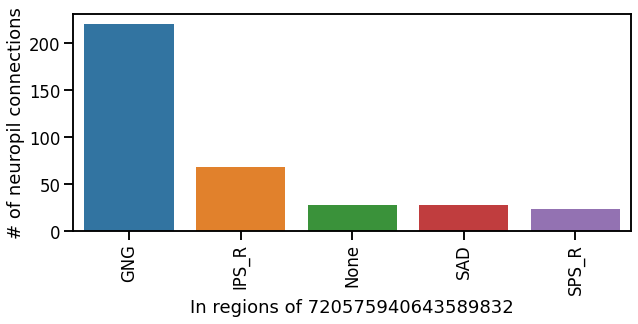

In [29]:
in_regions, in_counts = np.unique(syn_table[syn_table["post_pt_root_id"] == inspect_cid]["neuropil"], return_counts=True)
fig, ax = plt.subplots(1,1,figsize=(10,4))
sns.barplot(in_regions, in_counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("In regions of {}".format(inspect_cid))

In [30]:
# top 10 most visited neurons, in the forward MC
top10visited_rev = [nid2cid[n] for n in scc_g.get_vertices()[np.argsort(p_stationary_rev)[::-1][:10]]]
top10visited_rev

[720575940629540407,
 720575940637499738,
 720575940626565245,
 720575940613908903,
 720575940619446096,
 720575940605261600,
 720575940623788040,
 720575940617448193,
 720575940630915882,
 720575940614677983]

In [31]:
np.sort(p_stationary_rev)[::-1][:10]

array([0.01092847, 0.0095184 , 0.00943293, 0.00857243, 0.00312264,
       0.00300178, 0.00242984, 0.00235192, 0.00220612, 0.00215292])

In [32]:
np.sort(p_stationary_rev)[::-1][:10] / (1/scc_g.num_vertices())

array([674.38499845, 587.3712501 , 582.09696585, 528.99599528,
       192.69476341, 185.23684857, 149.94328183, 145.13467591,
       136.1375985 , 132.85432315])

In [33]:
inspect_cid = top10visited_rev[0]

Text(0.5, 0, 'out regions of 720575940629540407')

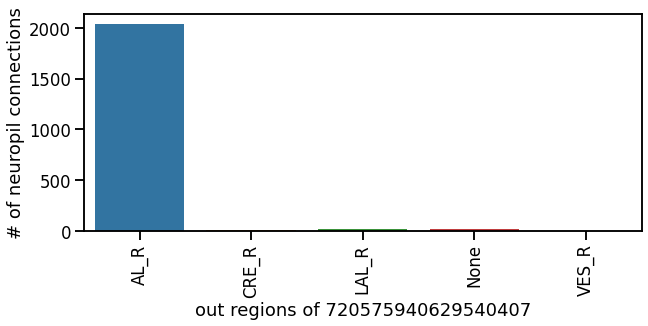

In [34]:
out_regions, out_counts = np.unique(syn_table[syn_table["pre_pt_root_id"] == inspect_cid]["neuropil"], return_counts=True)
fig, ax = plt.subplots(1,1,figsize=(10,4))
sns.barplot(out_regions, out_counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("out regions of {}".format(inspect_cid))

Text(0.5, 0, 'In regions of 720575940629540407')

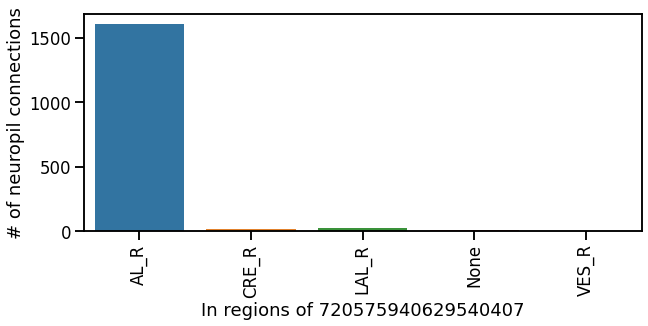

In [35]:
in_regions, in_counts = np.unique(syn_table[syn_table["post_pt_root_id"] == inspect_cid]["neuropil"], return_counts=True)
fig, ax = plt.subplots(1,1,figsize=(10,4))
sns.barplot(in_regions, in_counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("In regions of {}".format(inspect_cid))

In [36]:
## interestingly they are symmetric. I can't tell the name of these neurons.
## the top two both send most connections to two sides of LAL, CRE, AOTU, SIP, VES
## the top two both receive from GNG and one side of SPS, VES
## omit the 10th because it's in the mashroom body
vis_link(top10visited[:10])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

In [37]:
## as you can see they are all in the antennal lobe
vis_link(top10visited_rev)

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

In [38]:
# top 10 least visited neurons
top10leastvisited = [nid2cid[n] for n in scc_g.get_vertices()[np.argsort(p_stationary)[:10]]]
top10leastvisited

[720575940630193464,
 720575940620515293,
 720575940626482705,
 720575940630616139,
 720575940626049098,
 720575940629761017,
 720575940612258326,
 720575940616526420,
 720575940616623158,
 720575940621539113]

In [39]:
# top 10 least visited neurons
top10leastvisited_rev = [nid2cid[n] for n in scc_g.get_vertices()[np.argsort(p_stationary_rev)[:10]]]
top10leastvisited_rev

[720575940616374667,
 720575940615174086,
 720575940624234242,
 720575940614823647,
 720575940635964649,
 720575940631125156,
 720575940606594226,
 720575940610610841,
 720575940615411942,
 720575940619028144]

In [40]:
# they are poorly recontructed? imcomplete branches interact with GNG
# noisy synapses as well?
vis_link(top10leastvisited)

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

In [41]:
# they are poorly recontructed? imcomplete input / output
vis_link(top10leastvisited_rev)

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

In [42]:
L_chung

<61709x61709 sparse matrix of type '<class 'numpy.float64'>'
	with 2853165 stored elements in Compressed Sparse Row format>

In [43]:
%%time
from scipy.sparse import linalg
# L_chung_eigval, L_chung_eigvec = linalg.eigsh(L_chung, k=1, sigma=0, which='SM', maxiter=1e6, tol=1e-6)
L_chung_eigval, L_chung_eigvec = linalg.eigsh(L_chung, k=100, which='SM')

CPU times: user 3min 24s, sys: 1min 26s, total: 4min 50s
Wall time: 27 s


In [44]:
%%time
L_chung_rev_eigval, L_chung_rev_eigvec = linalg.eigsh(L_chung_rev, k=100, which='SM')

CPU times: user 3min 40s, sys: 1min 33s, total: 5min 13s
Wall time: 29.1 s


In [45]:
import pickle
with open('saved/v477topeigval.pickle', 'wb') as file:
    pickle.dump(L_chung_eigval, file)
with open('saved/v477topeigvec.pickle', 'wb') as file:
    pickle.dump(L_chung_eigvec, file)

In [48]:
# gap more than 5‰ connections
L_chung_gaps = np.arange(1, 100)[np.diff(L_chung_eigval) > 0.002]
L_chung_gaps

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 18, 27, 32, 36, 67])

In [49]:
# gap more than 5‰ connections
L_chung_rev_gaps = np.arange(1, 100)[np.diff(L_chung_rev_eigval) > 0.002]
L_chung_rev_gaps

array([ 1,  2,  4,  5,  6,  7,  9, 11, 17, 20, 30, 31, 42, 52, 57, 73, 81])

Text(0.5, 0, 'Rank')

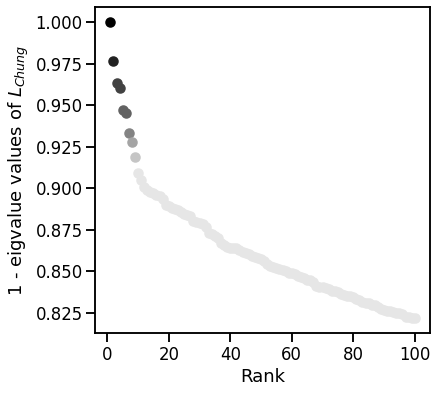

In [68]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
gap_prev = 0
alphas = np.linspace(0,0.9,len(L_chung_gaps)+1)
for i, gap in enumerate(L_chung_gaps):
    ax.scatter(range(gap_prev+1,gap+1), np.abs(1-L_chung_eigval[gap_prev:gap]), color=[alphas[i]]*3)
    gap_prev = gap
ax.scatter(range(gap_prev+1,101), np.abs(1-L_chung_eigval[gap_prev:]), color=[alphas[-1]]*3)
ax.set_ylabel("1 - eigvalue values of $L_{Chung}$")
ax.set_xlabel("Rank")

Text(0.5, 0, 'Rank')

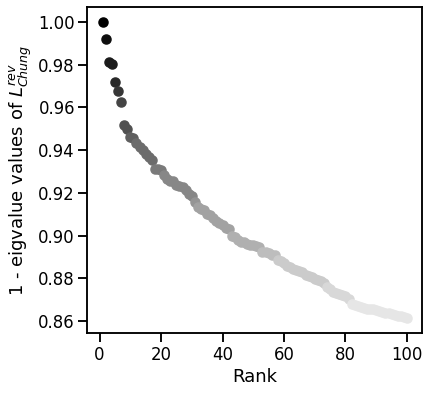

In [50]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
gap_prev = 0
alphas = np.linspace(0,0.9,len(L_chung_rev_gaps)+1)
for i, gap in enumerate(L_chung_rev_gaps):
    ax.scatter(range(gap_prev+1,gap+1), np.abs(1-L_chung_rev_eigval[gap_prev:gap]), color=[alphas[i]]*3)
    gap_prev = gap
ax.scatter(range(gap_prev+1,101), np.abs(1-L_chung_rev_eigval[gap_prev:]), color=[alphas[-1]]*3)
ax.set_ylabel("1 - eigvalue values of $L^{rev}_{Chung}$")
ax.set_xlabel("Rank")

Text(0.5, 0, 'Rank')

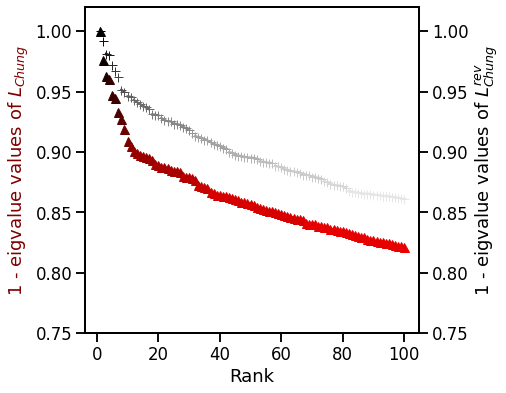

In [51]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
gap_prev = 0

ax2 = ax.twinx()

alphas = np.linspace(0,0.9,len(L_chung_rev_gaps)+1)
for i, gap in enumerate(L_chung_rev_gaps):
    ax2.plot(range(gap_prev+1,gap+1), np.abs(1-L_chung_rev_eigval[gap_prev:gap]), color=[alphas[i]]*3, marker='+')
    gap_prev = gap
ax2.plot(range(gap_prev+1,101), np.abs(1-L_chung_rev_eigval[gap_prev:]), color=[alphas[-1]]*3, marker='+')

gap_prev = 0
alphas = np.linspace(0.0,0.9,len(L_chung_gaps)+1)
for i, gap in enumerate(L_chung_gaps):
    ax.plot(range(gap_prev+1,gap+1), np.abs(1-L_chung_eigval[gap_prev:gap]), color=[alphas[i], 0, 0], marker='^')
    gap_prev = gap
ax.plot(range(gap_prev+1,101), np.abs(1-L_chung_eigval[gap_prev:]), color=[alphas[-1], 0, 0], marker='^')

ax.set_ylabel("1 - eigvalue values of $L_{Chung}$", color=(0.5,0,0))
ax2.set_ylabel("1 - eigvalue values of $L^{rev}_{Chung}$")
ax.set_ylim([0.75,1.02])
ax2.set_ylim([0.75,1.02])
ax.set_xlabel("Rank")

In [52]:
def block_graph(m, groups, weight='syn_count'):
    
    vw = m.new_vertex_property("int32_t")
    
    # assume vertex orders are aligned
    for i, v in enumerate(m.vertices()):
        if weight:
            vw[v] = groups[i]

    if weight:
        merge_g = gt.BlockState(m, b=groups, eweight=m.ep[weight])
    else:
        merge_g = gt.BlockState(m, b=groups)

    return merge_g

def summarize_block(blocks, norm=False):
    
    mg = blocks.get_bg()
    nr = blocks.get_nr()
    ers = blocks.get_ers()
    
    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = ers[e] / (nr[e.target()] * nr[e.source()])
        else:
            p_syn[e] = ers[e]
            
    block_sizes = [nr[v] for v in mg.vertices()]
    syn_prob = gt.adjacency(mg, weight=p_syn).todense()
            
    return block_sizes, syn_prob

##### 2.1.1 2-module structure

In [53]:
# bisect the brain via 2nd eigenvector
b2_groups = L_chung_eigvec[:,1] > 0

In [54]:
%%time
# get bisect results
scc_g_b2 = block_graph(scc_g, b2_groups)

CPU times: user 4.78 s, sys: 268 ms, total: 5.05 s
Wall time: 4.64 s


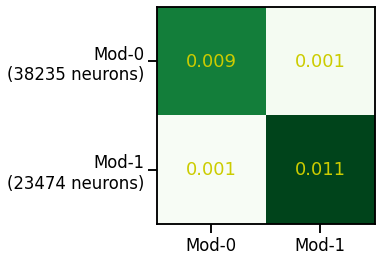

In [55]:
block_sizes, syn_prob = summarize_block(scc_g_b2, norm=True)

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(syn_prob, 'Greens')
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.3f}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.8,0))
ax.set_xticks(range(2))
ax.set_xticklabels(["Mod-{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(2))
ax.set_yticklabels(["Mod-{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

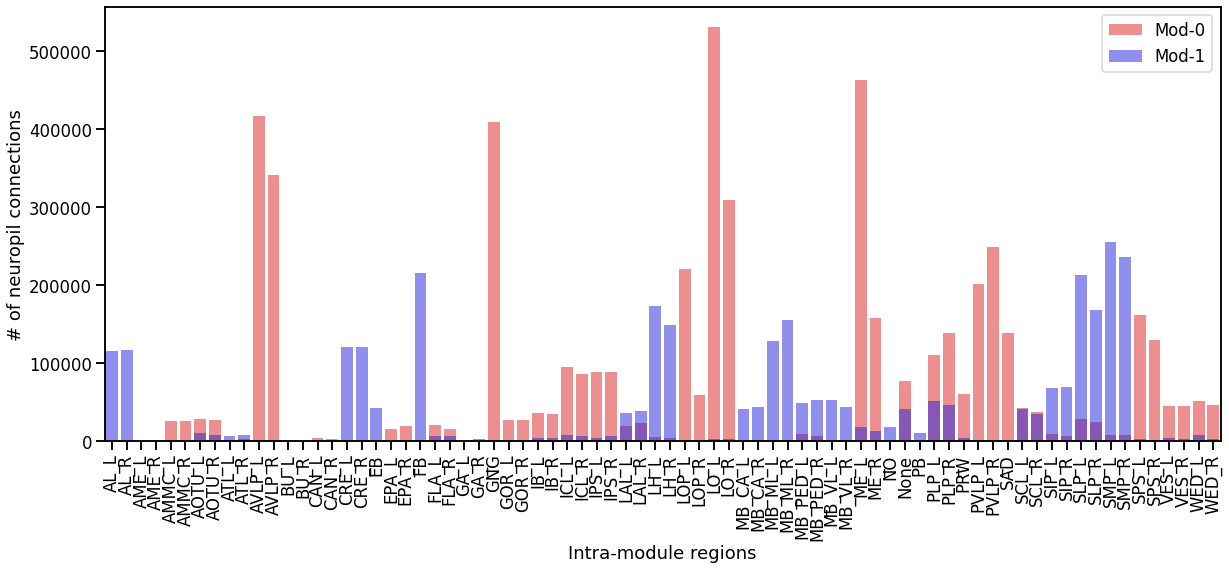

In [56]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = ['red', 'blue']

for b in range(2):
    mod_vs[b] = scc_g.get_vertices()[b2_groups == b]
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[b])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(2)]
for b in range(2):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(2):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors[b], alpha=0.5, label="Mod-{}".format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend()
plt.show()

In [57]:
n_mod = 2
total_intra_conn = {}
for reg in all_mod_reg:
    for b in range(n_mod):
        if reg in total_intra_conn.keys():
            total_intra_conn[reg] += mod_vs_reg_dicts[b][reg]
        else:
            total_intra_conn[reg] = mod_vs_reg_dicts[b][reg]

In [58]:
df = pd.DataFrame({'Mod-{}'.format(b): list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg) for b in range(n_mod)}, 
                 index=all_mod_reg)

In [59]:
# df.plot(kind='bar', stacked=True)

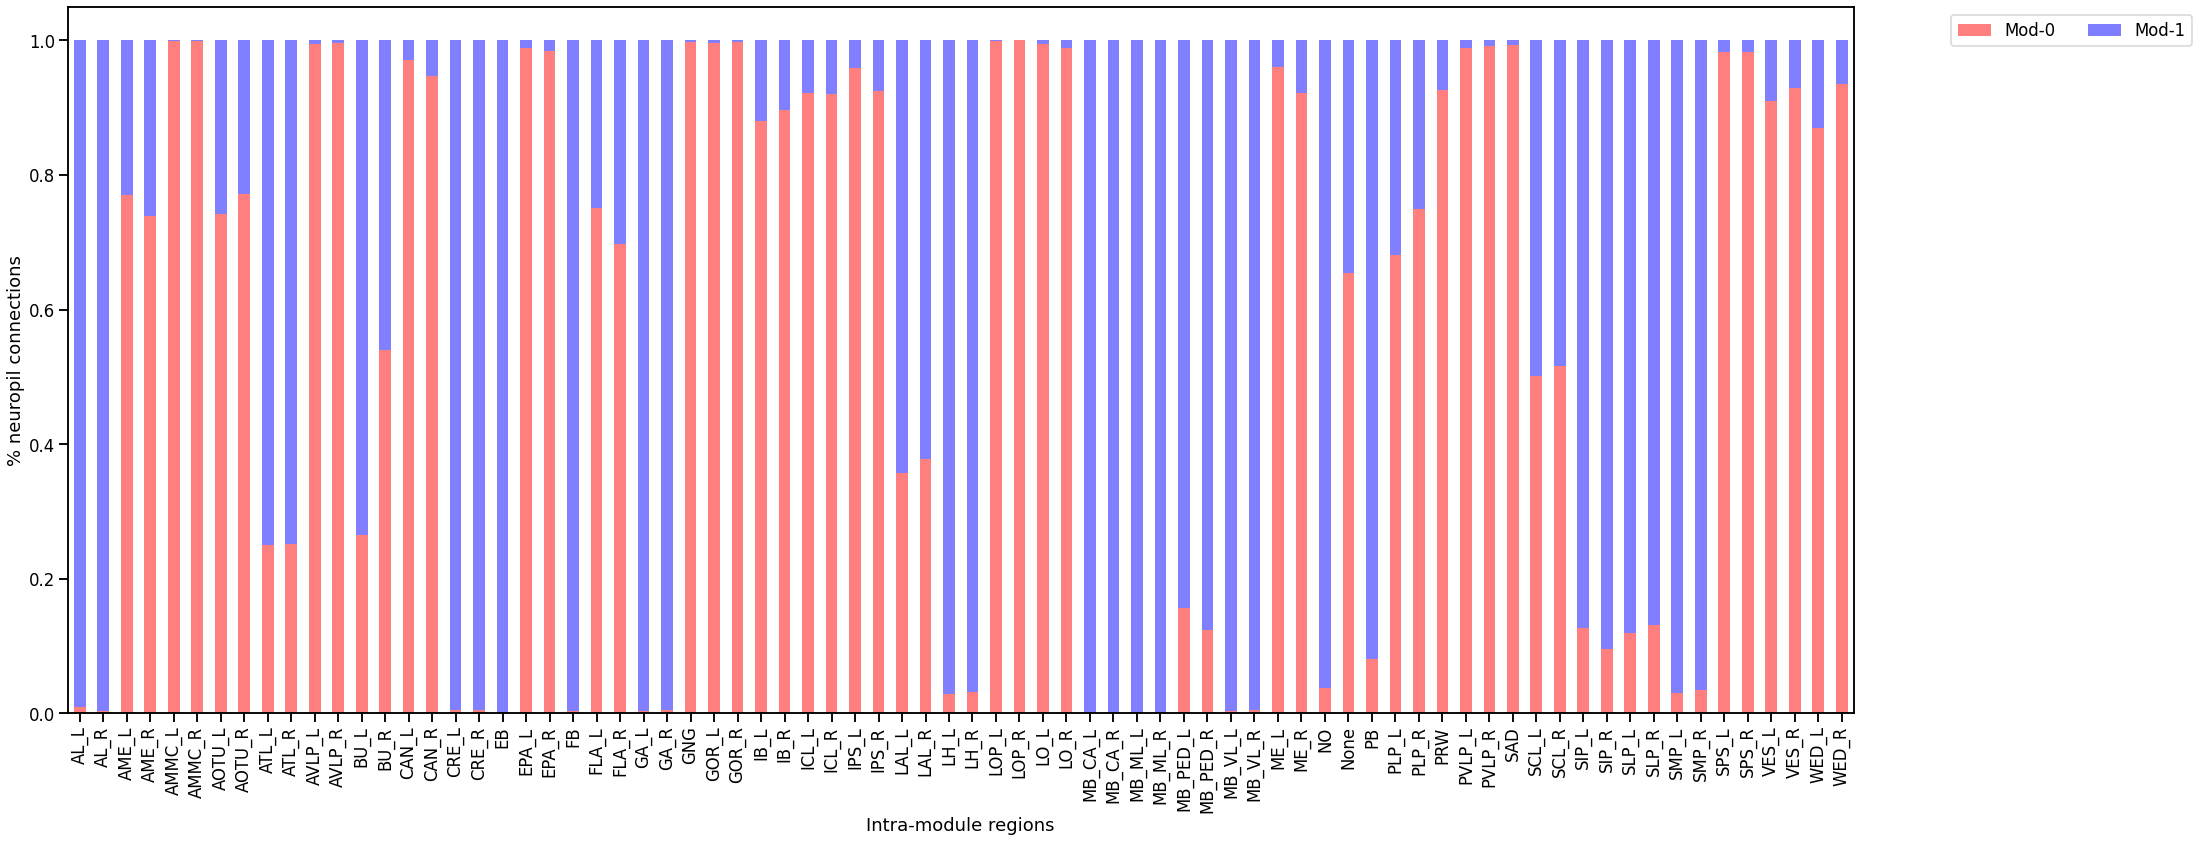

In [60]:
fig, ax = plt.subplots(1,1,figsize=(32,13))
# for b in range(33):
#     sns.barplot(all_mod_reg, 
#                 list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg), 
#                 color=colors(b/33), alpha=0.5, label='Mod-{}'.format(b), stacked=True)

df.plot(kind='bar', stacked=True, color=[colors[b] for b in range(n_mod)], alpha=0.5, ax=ax)    
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("% neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=6)
plt.show()

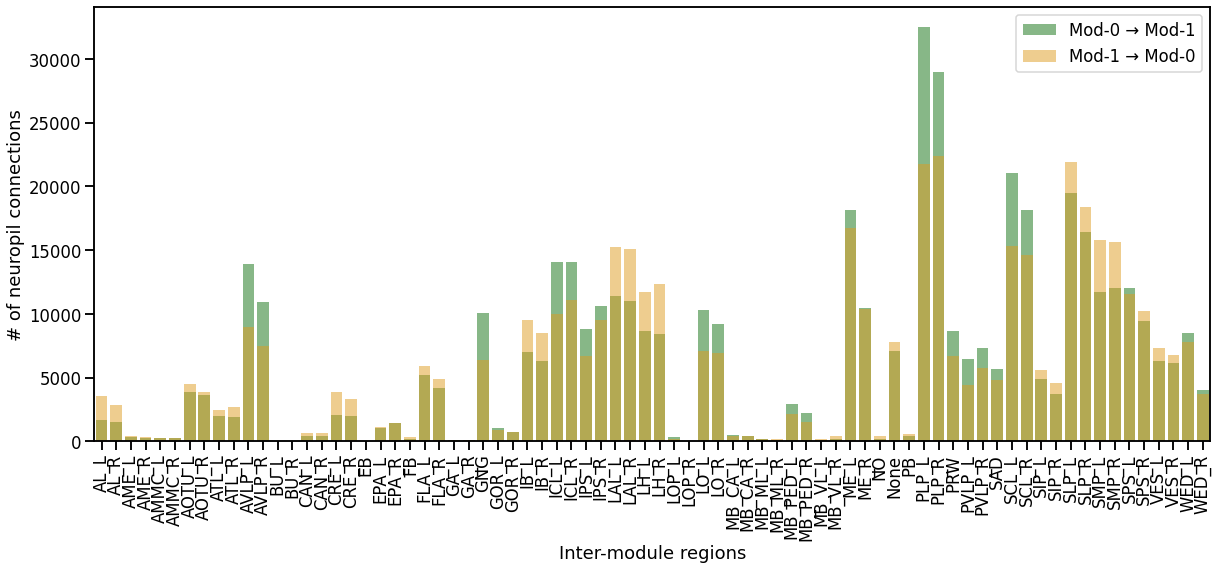

In [61]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = ['green', 'orange']

for b in range(2):
    mod_vs[b] = scc_g.get_vertices()[b2_groups == b]
for b in range(2):
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[(b+1)%2])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(2)]
for b in range(2):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(2):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors[b], alpha=0.5, 
                label='Mod-{} → Mod-{}'.format(b, (b+1)%2))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Inter-module regions")
ax.legend()
plt.show()

In [62]:
# spasely sample 100 neuorns from each module
vis_link([[nid2cid[i] for i in np.random.choice(mod_vs[i], 100, replace=False)] for i in range(2)], 'double')

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_graph%22%2C%22segments%22:%5B%22720575940619663809%22%2C%22720575940641105883%22%2C%22720575940629127806%22%2C%22720575940635496366%22%2C%22720575940617426203%22%2C%22720575940615496790%22%2C%22720575940643795492%22%2C%22720575940628921303%22%2C%22720575940615020447%22%2C%22720575940629674809%22%2C%22720575940626940932%22%2C%22720575940626562409%22%2C%22720575940634378135%22%2C%22720575940637342534%

In [63]:
# bisect the brain via 2nd eigenvector of rev L
b2_groups_rev = L_chung_rev_eigvec[:,1] > 0

In [64]:
%%time
# get bisect results
scc_g_b2_rev = block_graph(scc_g, b2_groups_rev)

CPU times: user 1.31 s, sys: 12 ms, total: 1.32 s
Wall time: 898 ms


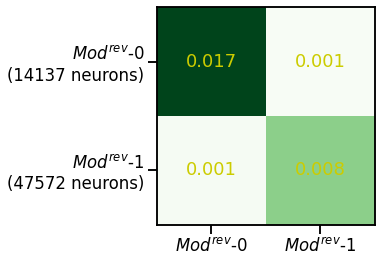

In [65]:
block_sizes, syn_prob = summarize_block(scc_g_b2_rev, norm=True)

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(syn_prob, 'Greens')
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.3f}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.8,0))
ax.set_xticks(range(2))
ax.set_xticklabels(["$Mod^{rev}$"+"-{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(2))
ax.set_yticklabels(["$Mod^{rev}$"+"-{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

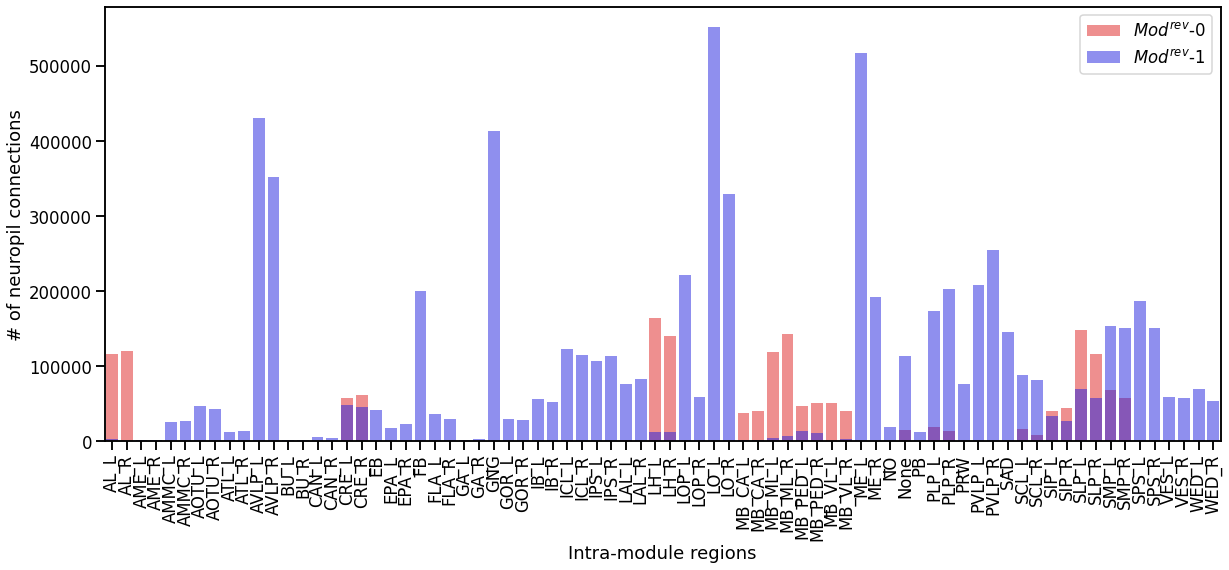

In [66]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = ['red', 'blue']

for b in range(2):
    mod_vs[b] = scc_g.get_vertices()[b2_groups_rev == b]
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[b])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(2)]
for b in range(2):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(2):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors[b], alpha=0.5, label="$Mod^{rev}$"+"-{}".format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend()
plt.show()

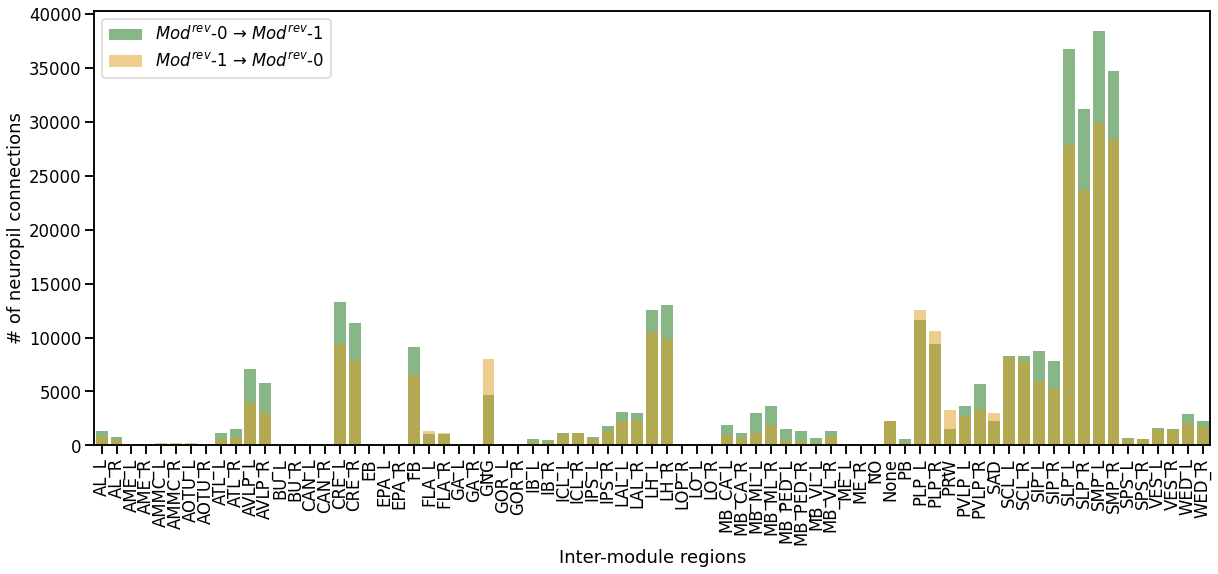

In [67]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = ['green', 'orange']

for b in range(2):
    mod_vs[b] = scc_g.get_vertices()[b2_groups_rev == b]
for b in range(2):
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[(b+1)%2])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(2)]
for b in range(2):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(2):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors[b], alpha=0.5, 
                label='$Mod^{rev}$'+'-{} → '.format(b)+'$Mod^{rev}$'+'-{}'.format((b+1)%2))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Inter-module regions")
ax.legend()
plt.show()

In [68]:
# spasely sample 100 neuorns from each module
vis_link([[nid2cid[i] for i in np.random.choice(mod_vs[i], 100, replace=False)] for i in range(2)], 'double')

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_graph%22%2C%22segments%22:%5B%22720575940620307806%22%2C%22720575940613563187%22%2C%22720575940631432403%22%2C%22720575940611068053%22%2C%22720575940621784575%22%2C%22720575940626919409%22%2C%22720575940621057123%22%2C%22720575940621077492%22%2C%22720575940625753621%22%2C%22720575940613494447%22%2C%22720575940615255993%22%2C%22720575940613345247%22%2C%22720575940619813637%22%2C%22720575940620917786%

##### 2.1.2 3-module structure

In [69]:
# trisect the brain via 2nd and 3rd eigenvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
neu_rep = normalize(L_chung_eigvec[:,1:3])
kmean = KMeans(n_clusters=3).fit(np.real(neu_rep))
b3_groups = kmean.labels_

In [70]:
%%time
# get trisect results
scc_g_b3 = block_graph(scc_g, b3_groups)

CPU times: user 1.09 s, sys: 36 ms, total: 1.12 s
Wall time: 791 ms


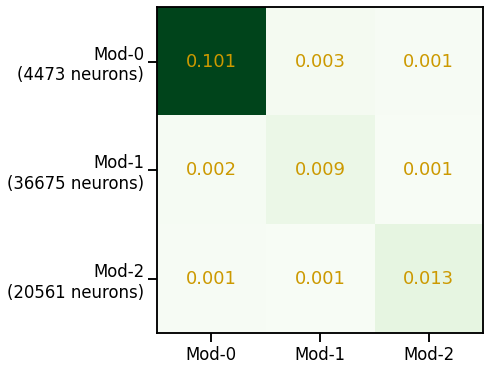

In [71]:
block_sizes, syn_prob = summarize_block(scc_g_b3, norm=True)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(syn_prob, 'Greens')
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, "{:.3f}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.6,0))
ax.set_xticks(range(3))
ax.set_xticklabels(["Mod-{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(3))
ax.set_yticklabels(["Mod-{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

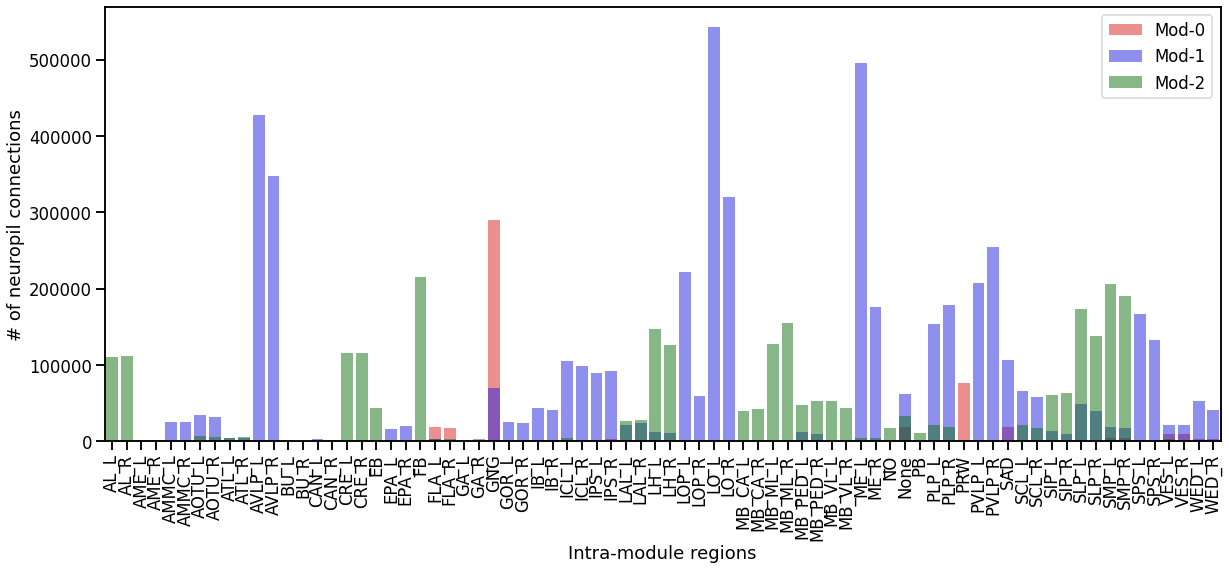

In [72]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = ['red', 'blue','green','orange']

for b in range(3):
    mod_vs[b] = scc_g.get_vertices()[b3_groups == b]
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[b])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(3)]
for b in range(3):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(3):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors[b], alpha=0.5, label='Mod-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend()
plt.show()

In [73]:
n_mod = 3
total_intra_conn = {}
for reg in all_mod_reg:
    for b in range(n_mod):
        if reg in total_intra_conn.keys():
            total_intra_conn[reg] += mod_vs_reg_dicts[b][reg]
        else:
            total_intra_conn[reg] = mod_vs_reg_dicts[b][reg]

In [74]:
df = pd.DataFrame({'Mod-{}'.format(b): list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg) for b in range(n_mod)}, 
                 index=all_mod_reg)

In [75]:
# df.plot(kind='bar', stacked=True)

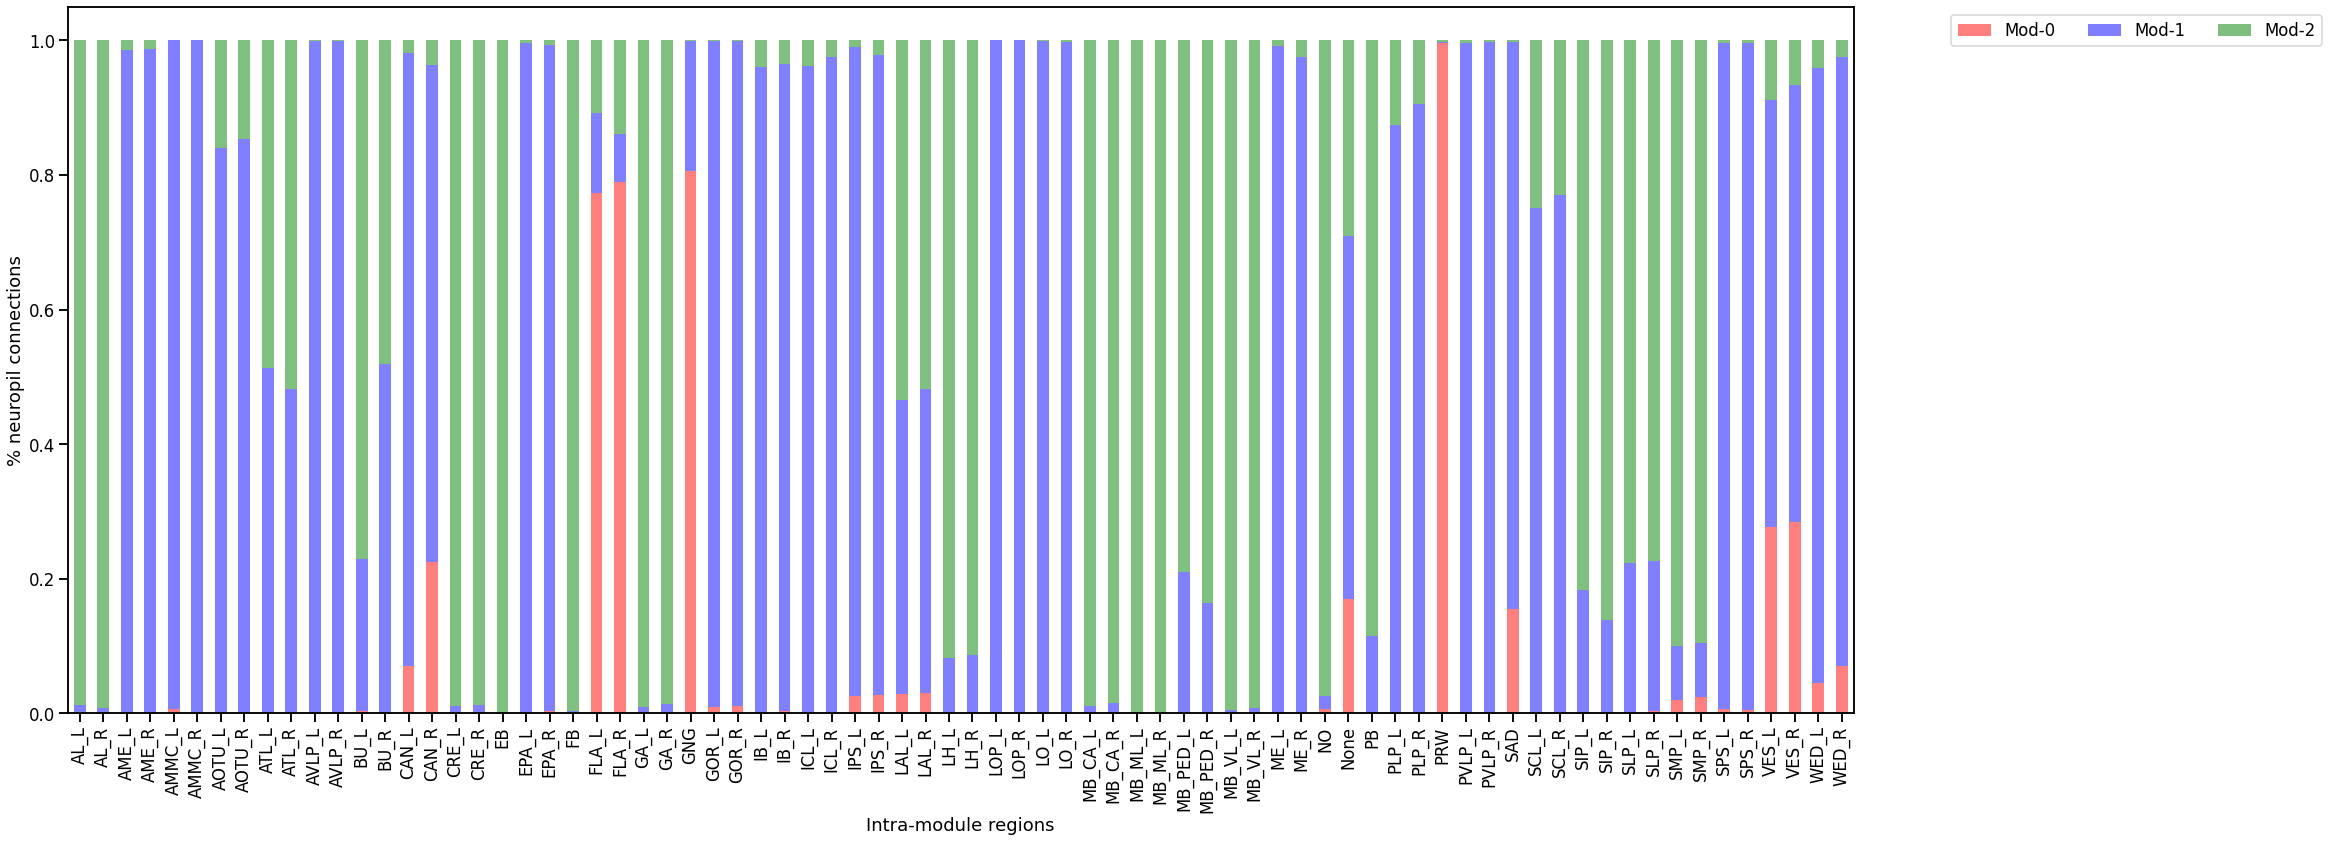

In [76]:
fig, ax = plt.subplots(1,1,figsize=(32,13))
# for b in range(33):
#     sns.barplot(all_mod_reg, 
#                 list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg), 
#                 color=colors(b/33), alpha=0.5, label='Mod-{}'.format(b), stacked=True)

df.plot(kind='bar', stacked=True, color=[colors[b] for b in range(n_mod)], alpha=0.5, ax=ax)    
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("% neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=6)
plt.show()

##### 2.1.3 5-module structure

In [ ]:
# trisect the brain via 2nd and 3rd eigenvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
neu_rep = normalize(L_chung_eigvec[:,1:5])
kmean = KMeans(n_clusters=5).fit(np.real(neu_rep))
b5_groups = kmean.labels_

In [ ]:
%%time
# get 5-block results
scc_g_b5 = block_graph(scc_g, b5_groups)

In [ ]:
block_sizes, syn_prob = summarize_block(scc_g_b5, norm=True)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(syn_prob, 'Greens')
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, "{:.3f}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(5))
ax.set_xticklabels(["Mod-{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(5))
ax.set_yticklabels(["Mod-{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

In [ ]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = ['red', 'blue','green','orange','gray']
n_class = 5

for b in range(n_class):
    mod_vs[b] = scc_g.get_vertices()[b5_groups == b]
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[b])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(n_class)]
for b in range(n_class):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(n_class):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors[b], alpha=0.5, label='Mod-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend()
plt.show()

In [ ]:
n_mod = 5
total_intra_conn = {}
for reg in all_mod_reg:
    for b in range(n_mod):
        if reg in total_intra_conn.keys():
            total_intra_conn[reg] += mod_vs_reg_dicts[b][reg]
        else:
            total_intra_conn[reg] = mod_vs_reg_dicts[b][reg]

In [ ]:
df = pd.DataFrame({'Mod-{}'.format(b): list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg) for b in range(n_mod)}, 
                 index=all_mod_reg)

In [ ]:
# df.plot(kind='bar', stacked=True)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(32,13))
# for b in range(33):
#     sns.barplot(all_mod_reg, 
#                 list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg), 
#                 color=colors(b/33), alpha=0.5, label='Mod-{}'.format(b), stacked=True)

df.plot(kind='bar', stacked=True, color=[colors[b] for b in range(n_mod)], alpha=0.5, ax=ax)    
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("% neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=6)
plt.show()

##### 2.1.4 6-module structure

In [77]:
# trisect the brain via 2nd and 3rd eigenvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
neu_rep = normalize(L_chung_eigvec[:,1:6])
kmean = KMeans(n_clusters=6).fit(np.real(neu_rep))
b6_groups = kmean.labels_

In [78]:
%%time
# get 6-block results
scc_g_b6 = block_graph(scc_g, b6_groups)

CPU times: user 1.28 s, sys: 12 ms, total: 1.29 s
Wall time: 819 ms


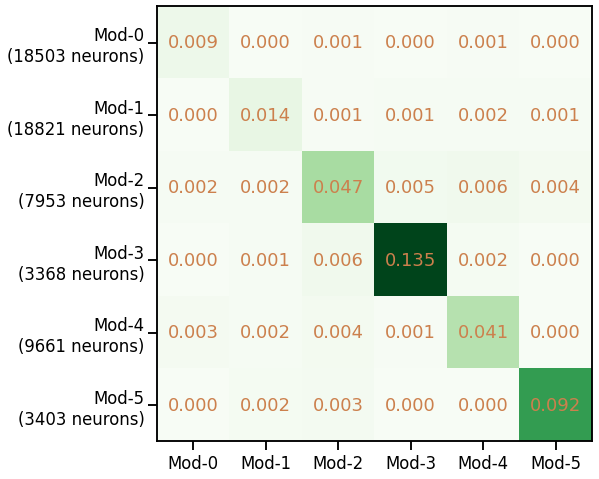

In [79]:
block_sizes, syn_prob = summarize_block(scc_g_b6, norm=True)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(syn_prob, 'Greens')
for i in range(6):
    for j in range(6):
        text = ax.text(j, i, "{:.3f}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(6))
ax.set_xticklabels(["Mod-{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(6))
ax.set_yticklabels(["Mod-{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

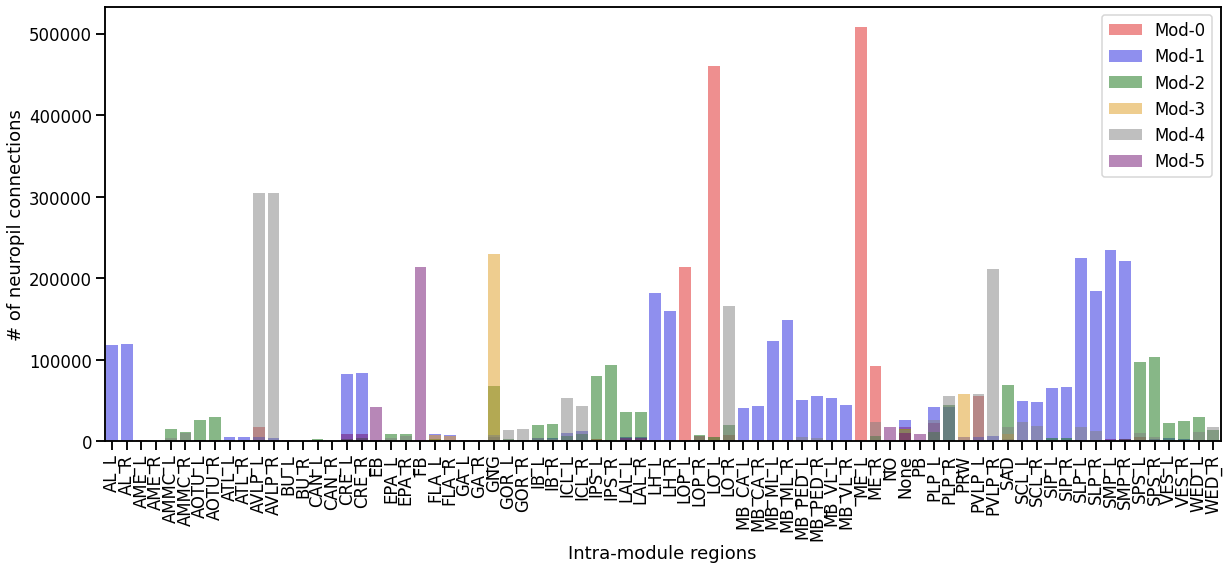

In [80]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = ['red', 'blue','green','orange','gray','purple']

for b in range(6):
    mod_vs[b] = scc_g.get_vertices()[b6_groups == b]
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[b])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(6)]
for b in range(6):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(6):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors[b], alpha=0.5, label='Mod-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend()
plt.show()

In [81]:
n_mod = 3
total_intra_conn = {}
for reg in all_mod_reg:
    for b in range(n_mod):
        if reg in total_intra_conn.keys():
            total_intra_conn[reg] += mod_vs_reg_dicts[b][reg]
        else:
            total_intra_conn[reg] = mod_vs_reg_dicts[b][reg]

In [82]:
df = pd.DataFrame({'Mod-{}'.format(b): list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg) for b in range(n_mod)}, 
                 index=all_mod_reg)

In [83]:
# df.plot(kind='bar', stacked=True)

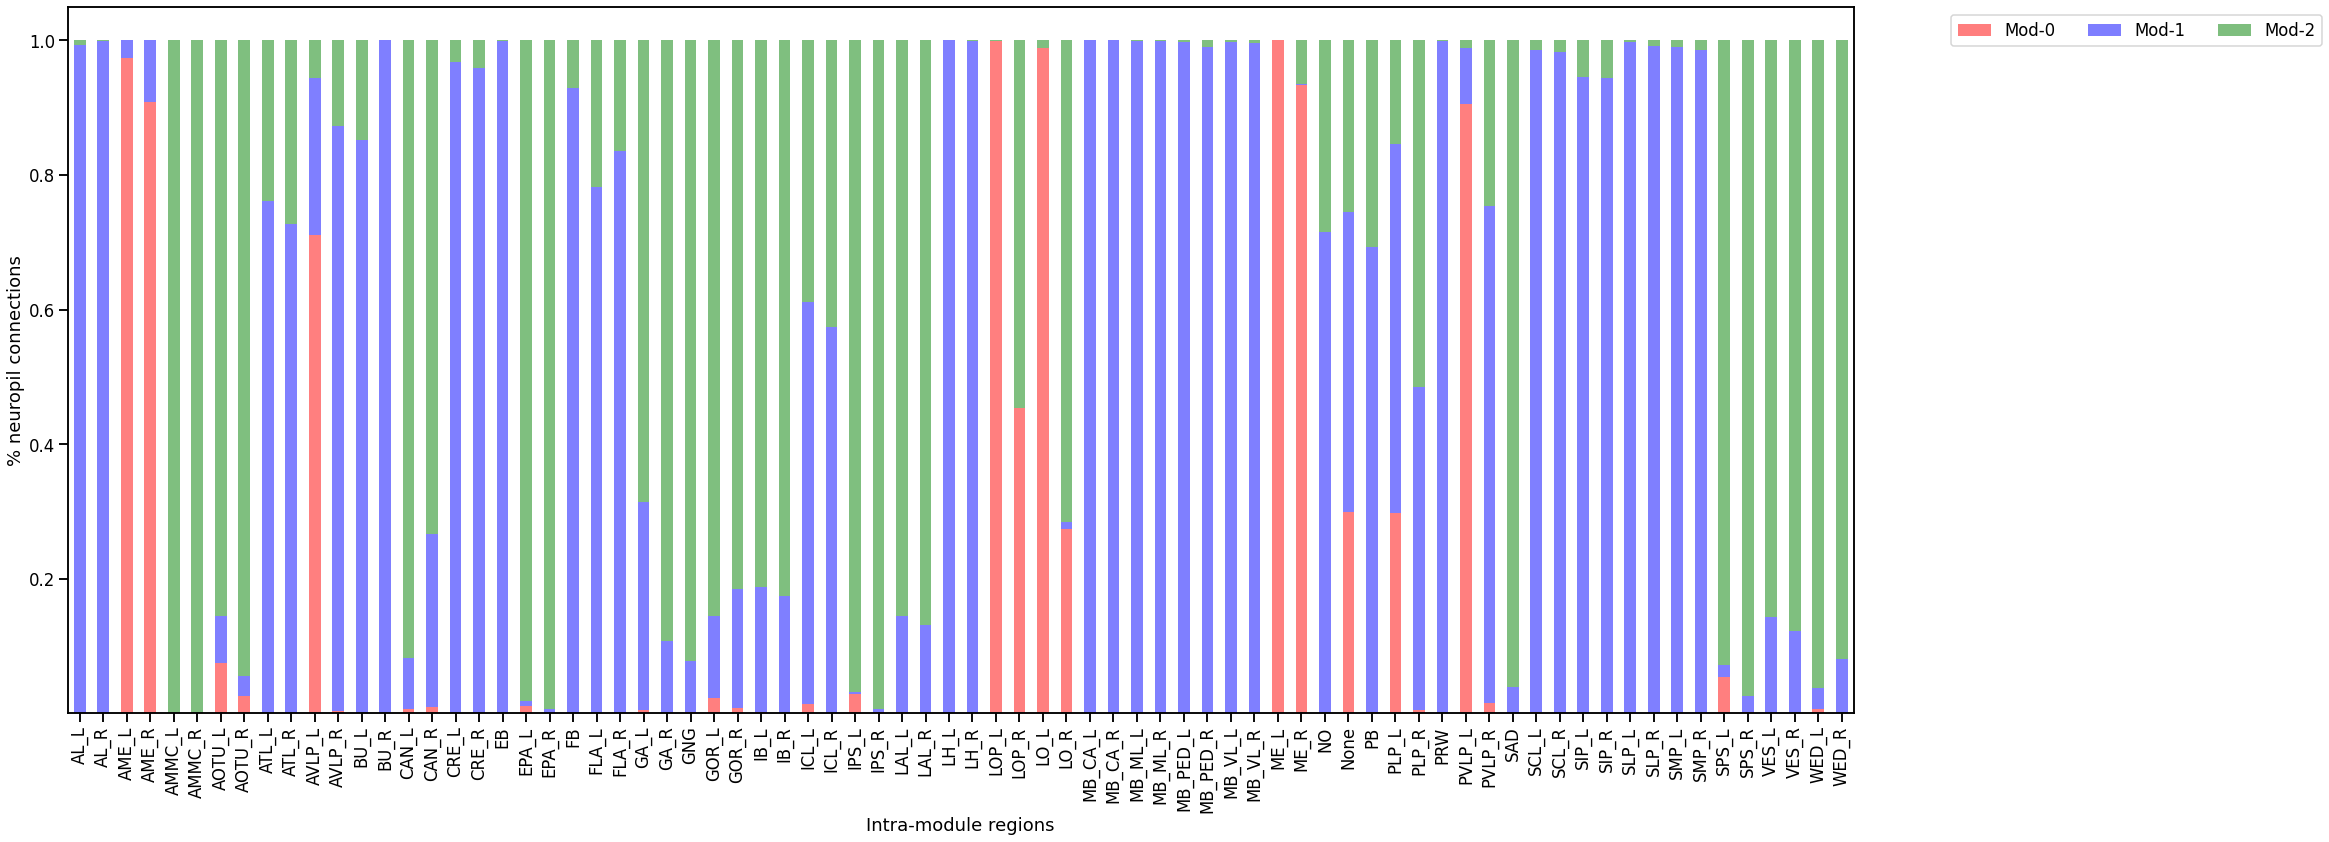

In [84]:
fig, ax = plt.subplots(1,1,figsize=(32,13))
# for b in range(33):
#     sns.barplot(all_mod_reg, 
#                 list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg), 
#                 color=colors(b/33), alpha=0.5, label='Mod-{}'.format(b), stacked=True)

df.plot(kind='bar', stacked=True, color=[colors[b] for b in range(n_mod)], alpha=0.5, ax=ax)    
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("% neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=6)
plt.show()

#### 2.1.4 Sanky diagram

In [ ]:
import plotly.graph_objects as go
from IPython.core.display import display
from IPython.display import IFrame

In [ ]:
# calculate source, target, values
def get_stv(source_labels, target_labels):
    s, t, v = [], [], []
    links, values = np.unique(list(zip(source_labels, target_labels)), 
                      axis=0, return_counts=True)
    for i in range(len(links)):
        s.append(links[i][0])
        t.append(links[i][1])
        v.append(values[i])
        
    return s, t, v

In [ ]:
chung_cls = [0, b2_groups, b3_groups, b5_groups, b6_groups]
total_num_block = 0
source, target, value = [], [], []

# recursive flatten
flatten = lambda a:[element for item in a for element in flatten(item)] if type(a) is list else [a]

label = flatten([["{}-{}".format(i+1,j) for j in range(i+1)] for i in range(6) if i != 3])

for i in range(4):
    if i > 0 and i < 3:
        stmp, ttmp, vtmp = get_stv(chung_cls[i] + total_num_block, 
                               chung_cls[i+1] + total_num_block + i + 1)
        total_num_block = total_num_block + i + 1
    elif i >= 3:
        stmp, ttmp, vtmp = get_stv(chung_cls[i] + total_num_block, 
                               chung_cls[i+1] + total_num_block + i + 2)
        total_num_block = total_num_block + i + 2
    else:
        stmp, ttmp, vtmp = get_stv(np.zeros(scc_g.num_vertices()) + total_num_block, 
                               chung_cls[i+1] + total_num_block + i + 1)
        total_num_block = total_num_block + i + 1
        
    source = source + stmp
    target = target + ttmp
    value = value + vtmp

In [ ]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)

In [ ]:
fig = go.Figure(data)
fig.write_html('figures/sankey-chung-cls.html')
display(IFrame('figures/sankey-chung-cls.html', width=900, height=600))

##### 2.1.5 12-module structure

In [ ]:
# trisect the brain via 2nd and 3rd eigenvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
neu_rep = normalize(L_chung_eigvec[:,1:12])
kmean = KMeans(n_clusters=12).fit(np.real(neu_rep))
b12_groups = kmean.labels_

In [ ]:
%%time
# get bisect results
scc_g_b12 = block_graph(scc_g, b12_groups)

In [ ]:
block_sizes, syn_prob = summarize_block(scc_g_b12, norm=True)

fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(syn_prob, 'Greens')
for i in range(12):
    for j in range(12):
        text = ax.text(j, i, "{:.3f}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(12))
ax.set_xticklabels(["Mod-{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(12))
ax.set_yticklabels(["Mod-{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

In [ ]:
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = plt.cm.Paired

for b in range(12):
    mod_vs[b] = scc_g.get_vertices()[b12_groups == b]
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[b])], 
                                       return_counts=True)
from functools import reduce
all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(12)]
for b in range(12):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(12):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors(b), alpha=0.5, label='Mod-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend()
plt.show()

##### 2.1.6 28-module structure

In [85]:
# trisect the brain via 2nd and 3rd eigenvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
neu_rep = normalize(L_chung_eigvec[:,1:32])
kmean = KMeans(n_clusters=32).fit(np.real(neu_rep))
b32_groups = kmean.labels_

In [88]:
import pickle
m32dict = dict(zip([scc_g.vp['cellid'][v] for v in scc_g.vertices()], b32_groups)) #len(b32_groups)
pickle.dump
with open('saved/b32_cellid_v447.pickle', 'wb') as f:
    pickle.dump(m32dict, f, pickle.HIGHEST_PROTOCOL)

In [91]:
# import csv
# dump_mod32 = [{'cell_id': k, 'mod_id': m32dict[k]} for k in m32dict.keys()]
# with open('saved/b32_cellid_v447.csv', 'w') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=['cell_id', 'mod_id'])
#     writer.writeheader()
#     writer.writerows(dump_mod32)

In [ ]:
# with open("./saved/b28_groups.data", 'wb') as f:
#     np.save(f, b28_groups)

In [92]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
tsne_b32 = tsne.fit_transform(neu_rep)

CPU times: user 24min 25s, sys: 23.7 s, total: 24min 49s
Wall time: 4min 50s


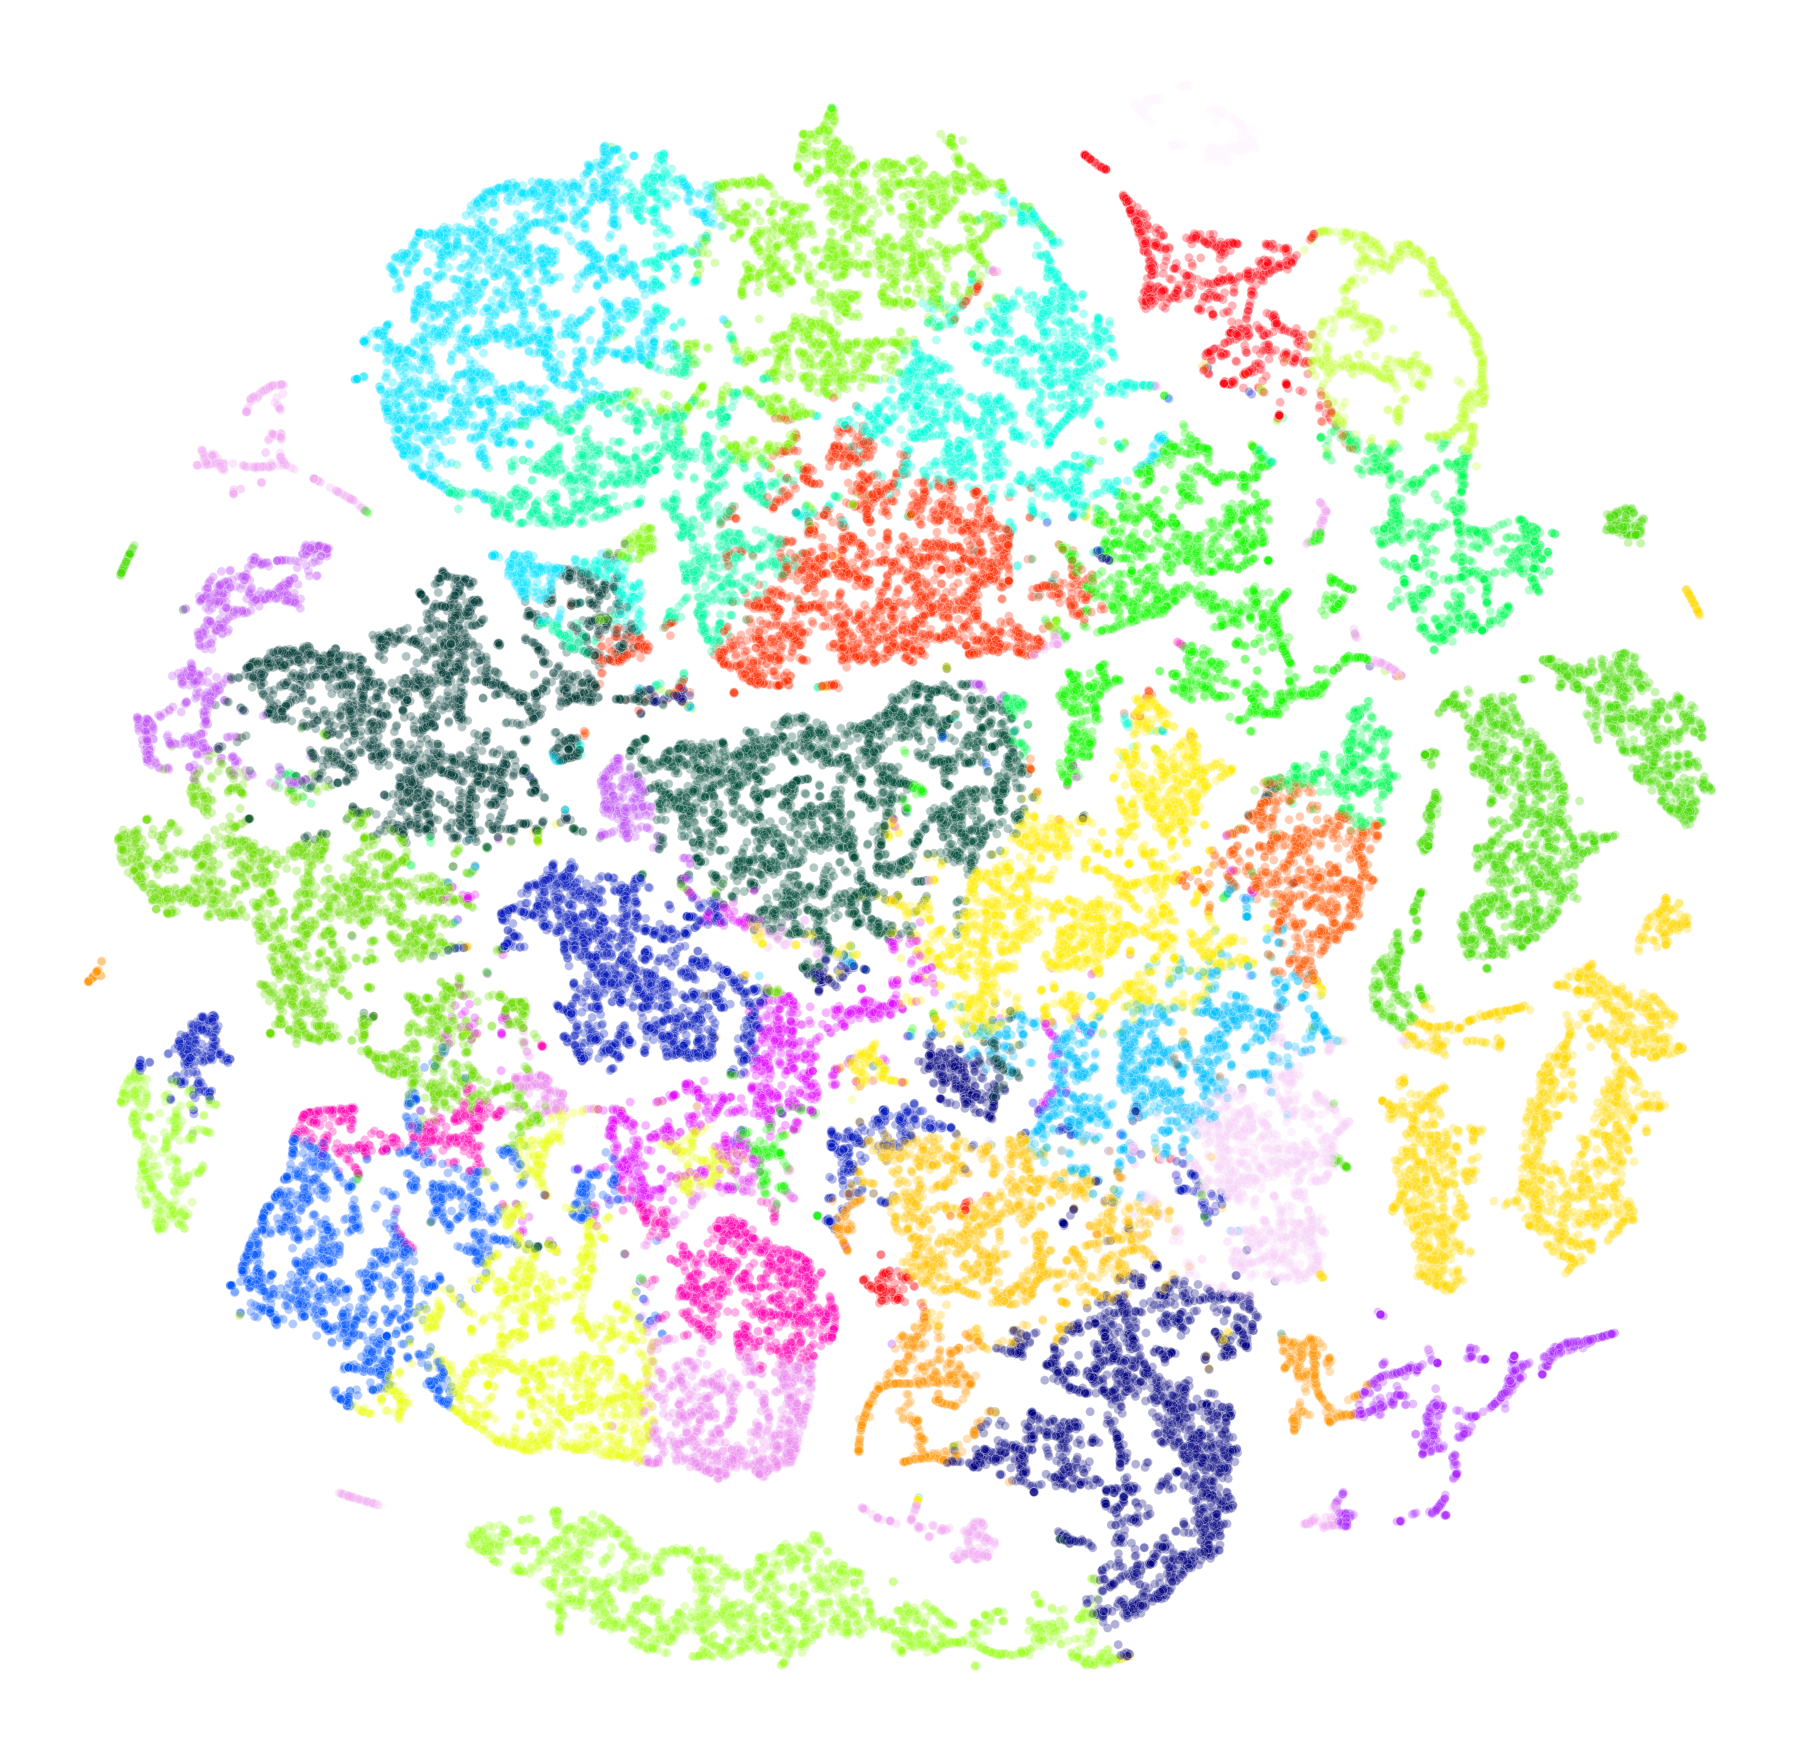

In [93]:
fig, ax = plt.subplots(1,1,figsize=(32,32))
sns.scatterplot(
    x=tsne_b32[:,0], y=tsne_b32[:,1],
    hue=b32_groups/32,
    palette=plt.cm.gist_ncar,
    legend=False,
    alpha=0.3
)
ax.axis("off")
plt.show()

In [94]:
%%time
# get 33-block results
scc_g_b32 = block_graph(scc_g, b32_groups)

CPU times: user 1.42 s, sys: 16 ms, total: 1.44 s
Wall time: 900 ms


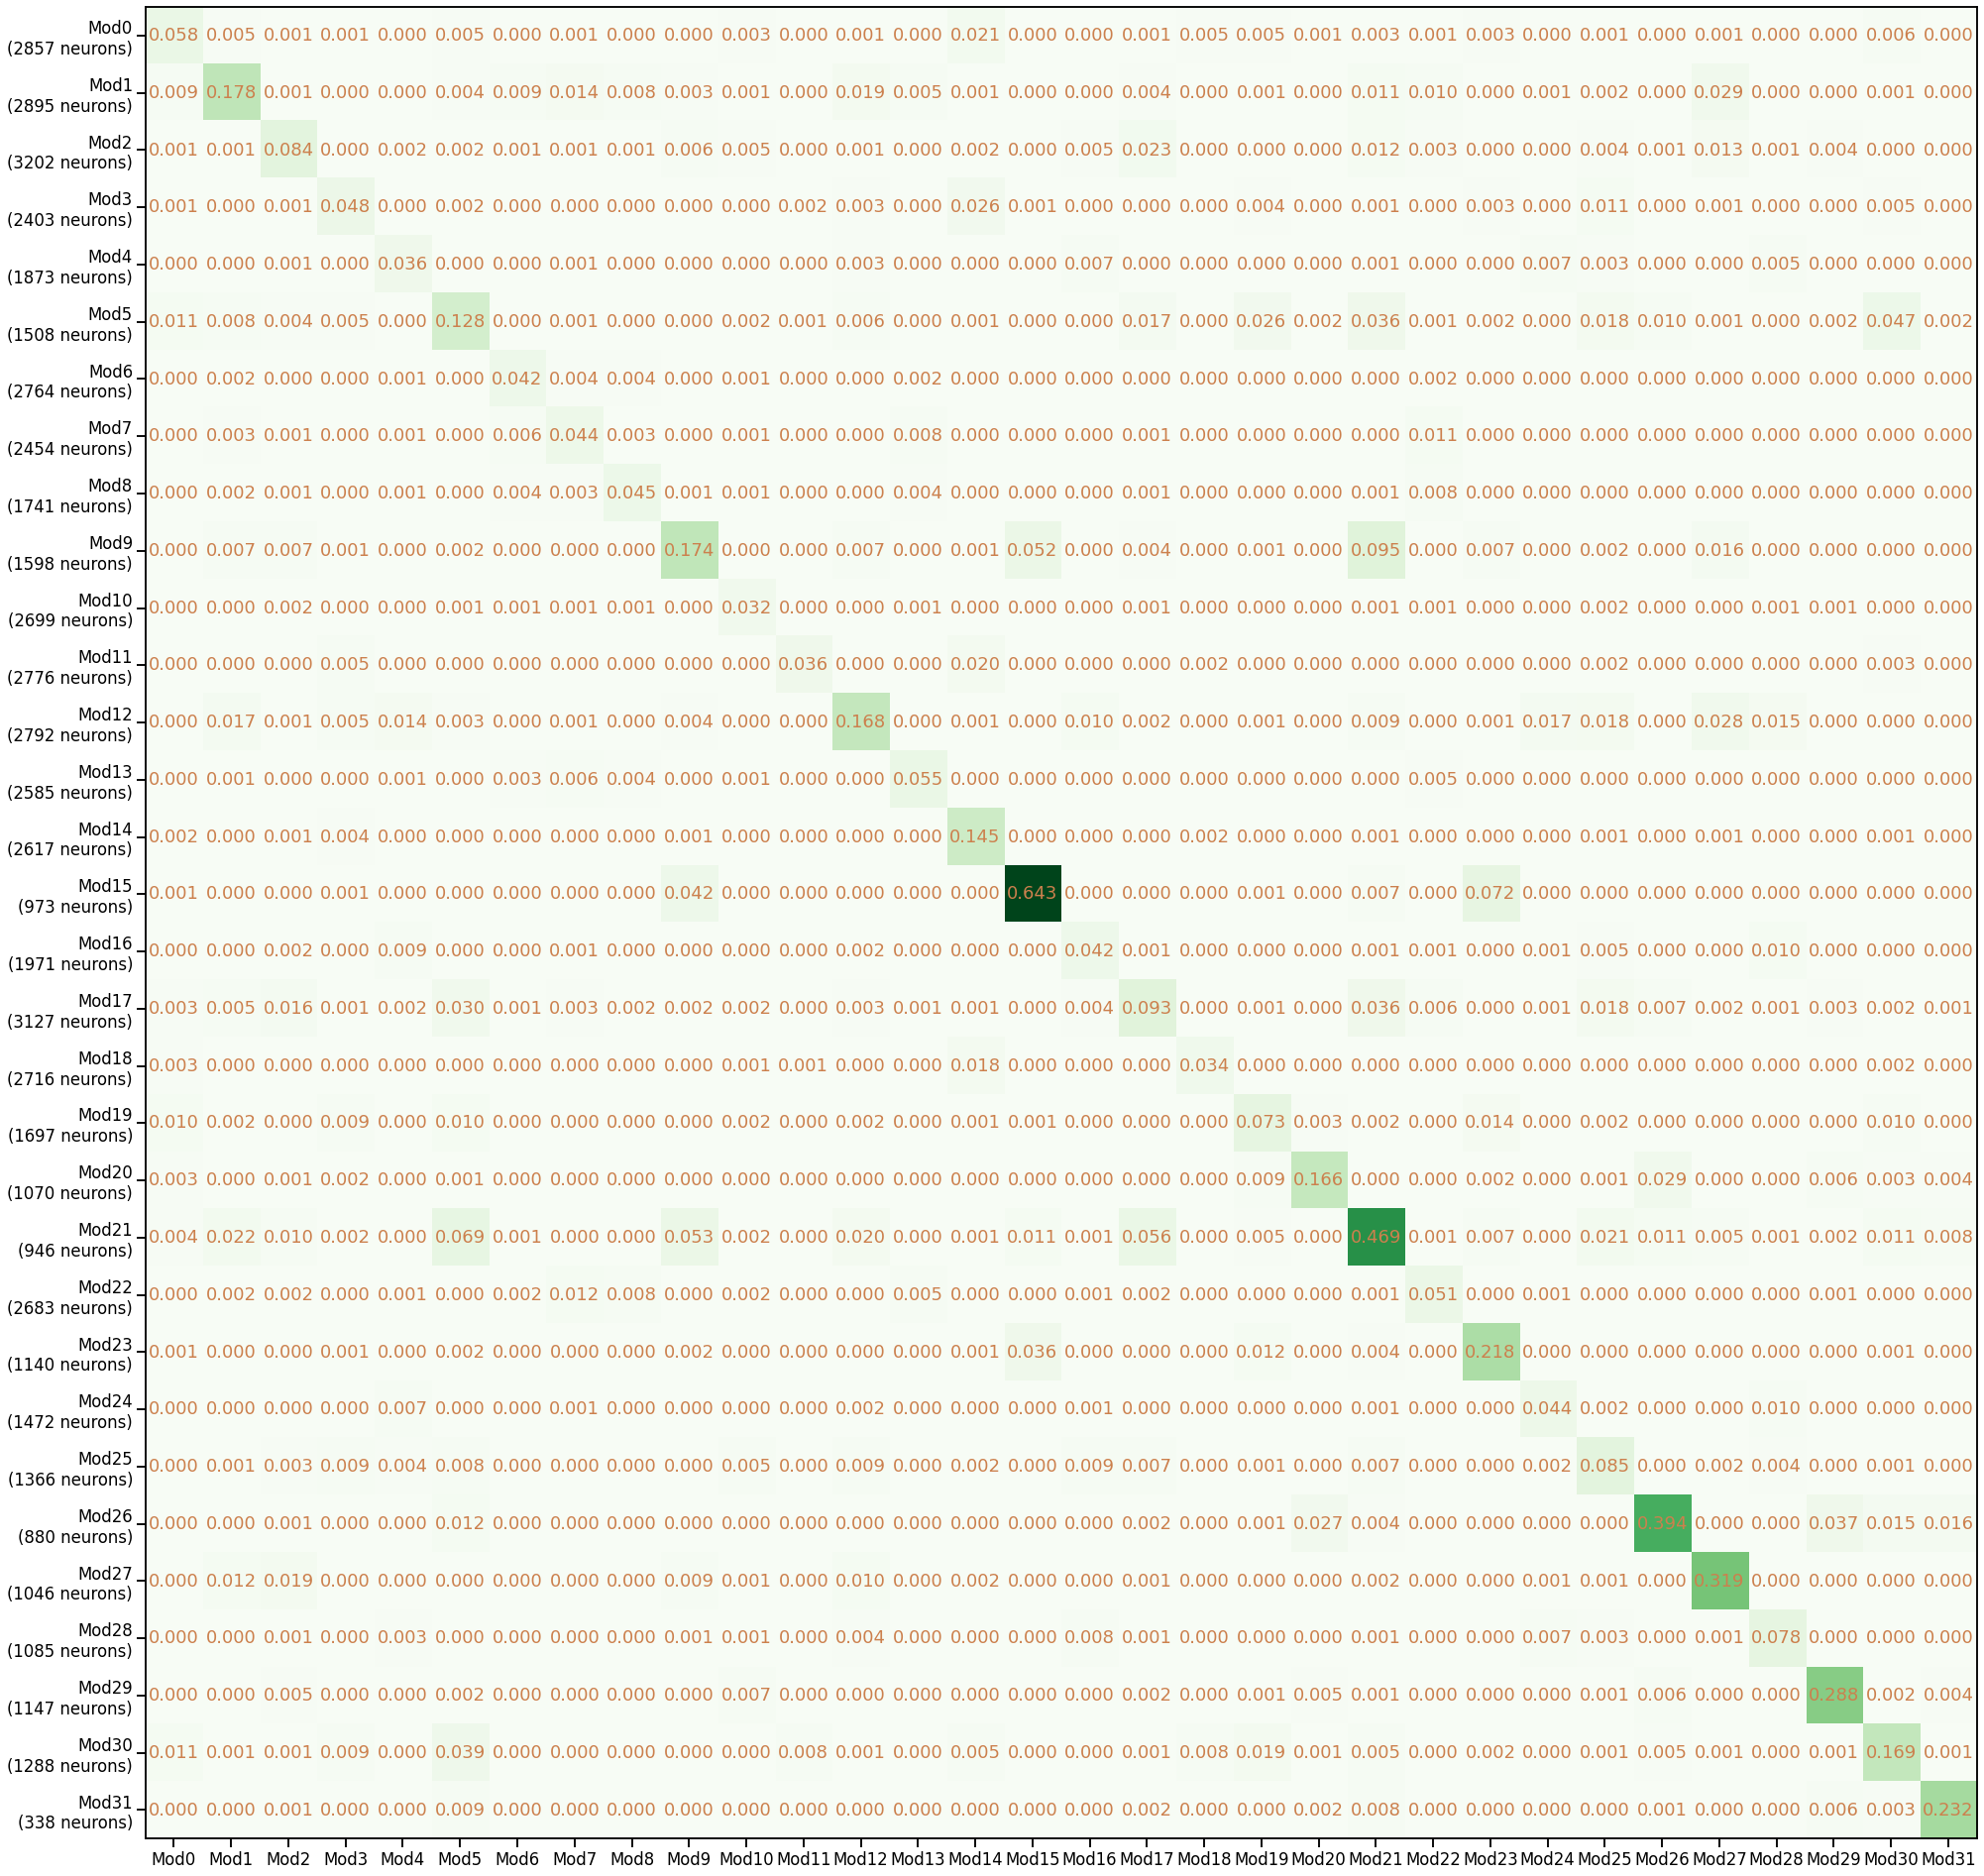

In [95]:
block_sizes, syn_prob = summarize_block(scc_g_b32, norm=True)

fig, ax = plt.subplots(1,1,figsize=(34,34))
ax.imshow(syn_prob, 'Greens')
for i in range(32):
    for j in range(32):
        text = ax.text(j, i, "{:.3f}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(32))
ax.set_xticklabels(["Mod{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(32))
ax.set_yticklabels(["Mod{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

In [96]:
from functools import reduce
mod_vs = {}
mod_vs_reg, mod_vs_reg_cnt = {}, {}
colors = plt.cm.gist_ncar

for b in range(32):
    mod_vs[b] = scc_g.get_vertices()[b32_groups == b]
    mod_vs_reg[b], mod_vs_reg_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
                                                             & syn_table["post_nid"].isin(mod_vs[b])], 
                                       return_counts=True)

all_mod_reg = reduce(np.union1d, (mod_vs_reg.values()))
mod_vs_reg_dicts = [{k:mod_vs_reg_cnt[b][i] for i, k in enumerate(mod_vs_reg[b])} for b in range(32)]
for b in range(32):
    for reg in all_mod_reg:
        if reg not in mod_vs_reg_dicts[b].keys():
            mod_vs_reg_dicts[b][reg] = 0

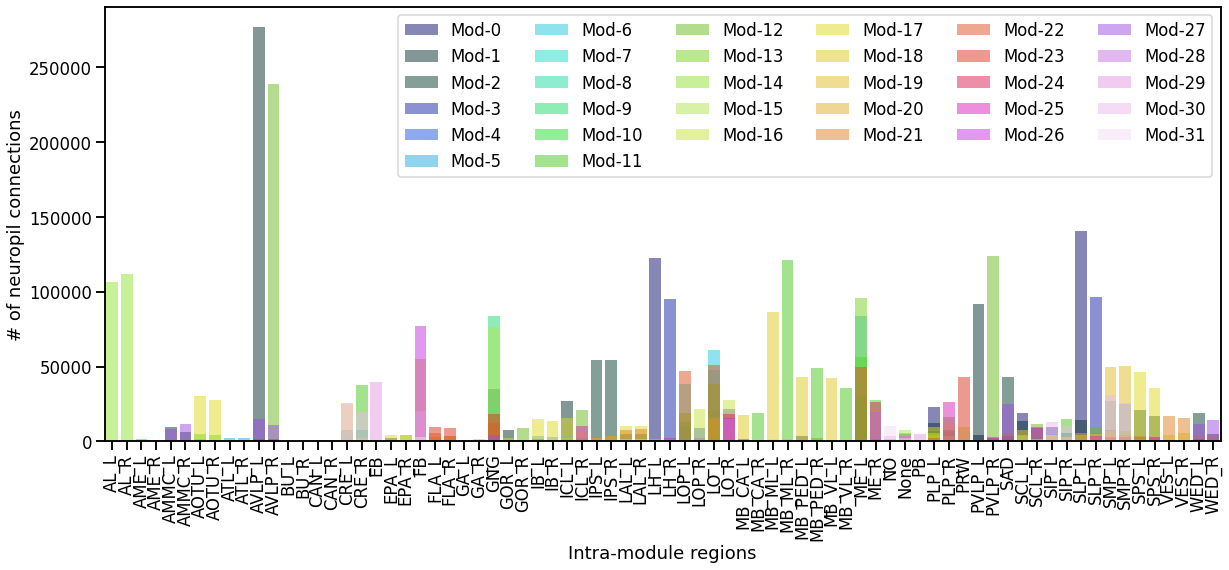

In [97]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(32):
    sns.barplot(all_mod_reg, 
                list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors(b/32), alpha=0.5, label='Mod-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend(ncol=6)
plt.show()

In [98]:
total_intra_conn = {}
for reg in all_mod_reg:
    for b in range(32):
        if reg in total_intra_conn.keys():
            total_intra_conn[reg] += mod_vs_reg_dicts[b][reg]
        else:
            total_intra_conn[reg] = mod_vs_reg_dicts[b][reg]

In [99]:
df = pd.DataFrame({'Mod-{}'.format(b): list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg) for b in range(32)}, 
                 index=all_mod_reg)

In [ ]:
# df.plot(kind='bar', stacked=True)

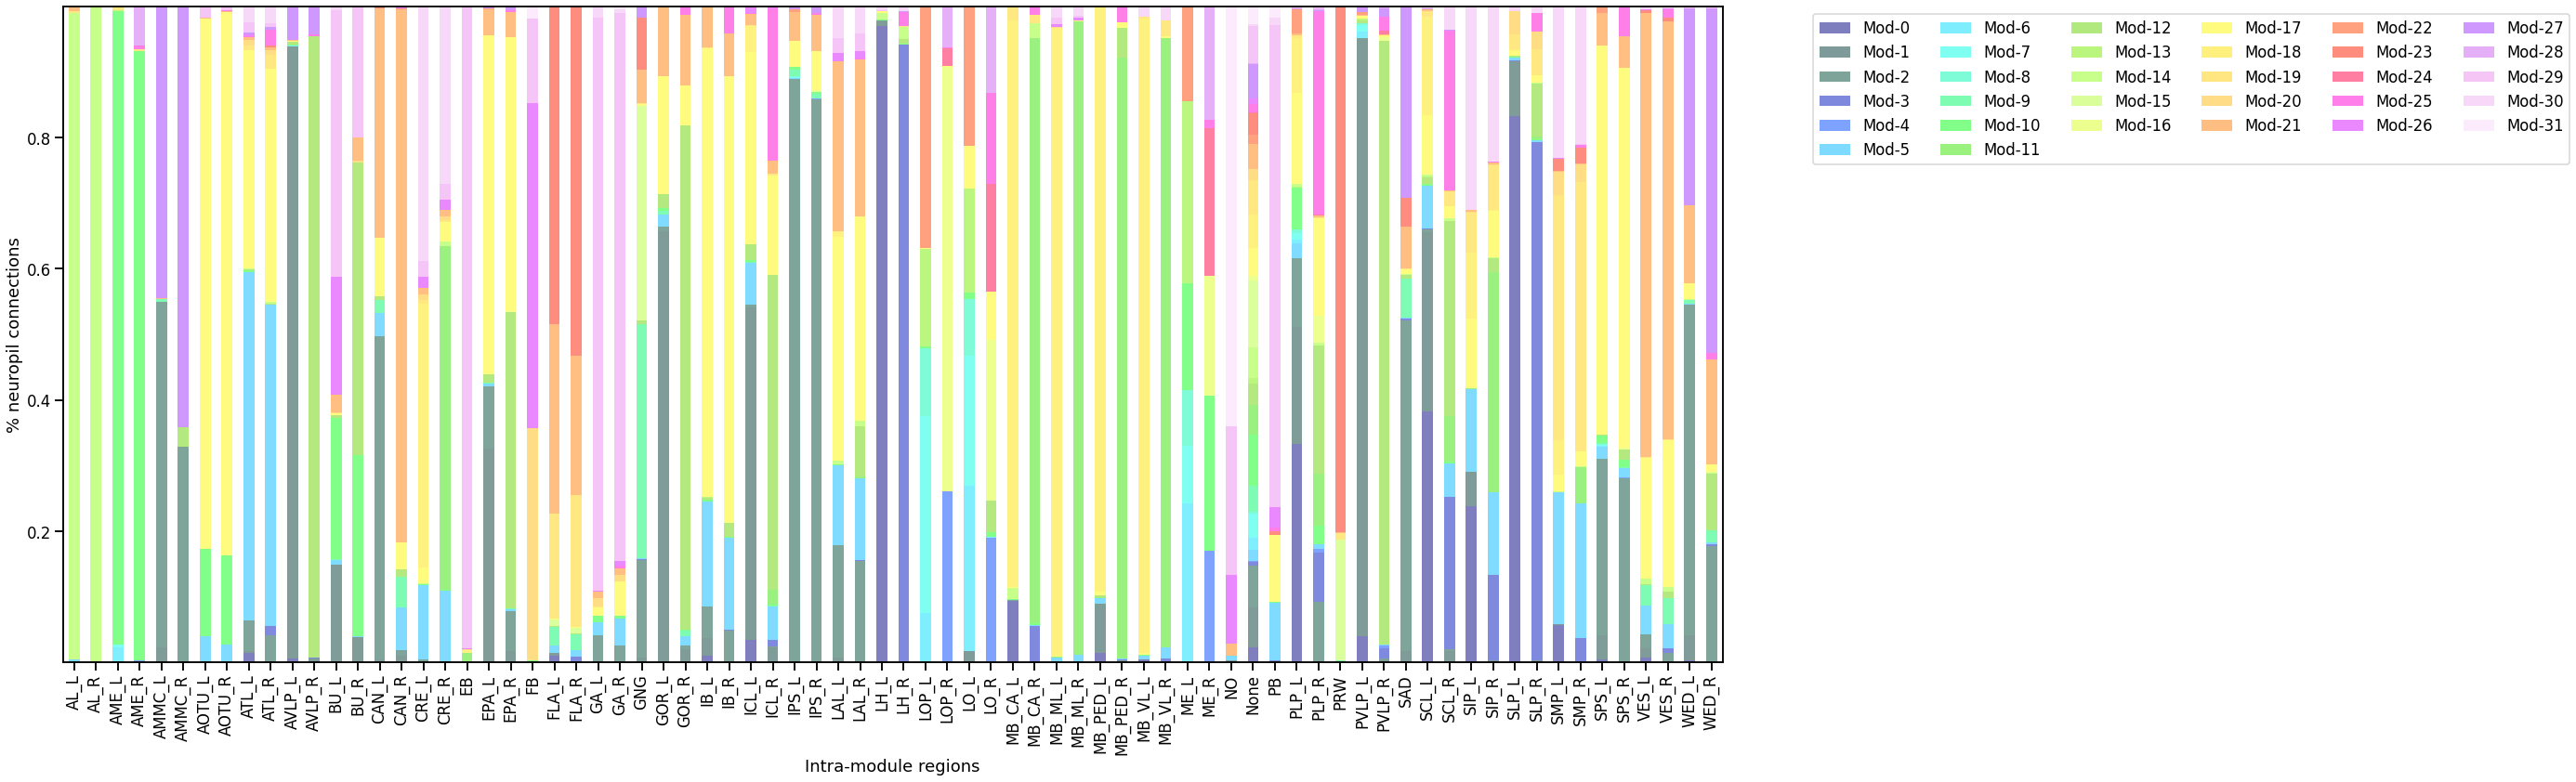

In [128]:
fig, ax = plt.subplots(1,1,figsize=(32,13))
# for b in range(33):
#     sns.barplot(all_mod_reg, 
#                 list(mod_vs_reg_dicts[b][reg] / total_intra_conn[reg] for reg in all_mod_reg), 
#                 color=colors(b/33), alpha=0.5, label='Mod-{}'.format(b), stacked=True)

df.plot(kind='bar', stacked=True, color=[colors(b/32) for b in range(32)], alpha=0.5, ax=ax)    
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("% neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=6)
plt.show()

In [106]:
fdir = "~/seungmount/research/runzhey/datasets/FlyWire/{}/coarse_cell_classes_{}.feather".format(ver, ver)
ninfo_table = pd.read_feather(fdir)

In [114]:
cell_class_dict = {r["root_id"]: r["class"] for _, r in ninfo_table.iterrows()}

In [119]:
np.unique(ninfo_table['class'])

array(['Ascending', 'Central Brain', 'Descending', 'Optic Lobe',
       'Sensory', 'Visual Projection'], dtype=object)

In [123]:
def cell_class_lookup(cid):
    if cid in cell_class_dict.keys():
        return cell_class_dict[cid]
    else:
        return "Unknown"

In [127]:
for i in range(32):
    classes, classes_cnt = np.unique([cell_class_lookup(nid2cid[i]) for i in mod_vs[i]], return_counts=True)
    print("Mod-{}".format(i))
    print(classes)
    print(classes_cnt)
    print()

Mod-0
['Ascending' 'Central Brain' 'Descending' 'Sensory' 'Unknown'
 'Visual Projection']
[  20 2707    4    1    1  124]

Mod-1
['Ascending' 'Central Brain' 'Descending' 'Sensory' 'Unknown'
 'Visual Projection']
[ 112 2229   29    1    2  522]

Mod-2
['Ascending' 'Central Brain' 'Descending' 'Optic Lobe' 'Sensory'
 'Visual Projection']
[ 112 2535  326    4  185   40]

Mod-3
['Ascending' 'Central Brain' 'Descending' 'Sensory' 'Unknown'
 'Visual Projection']
[  20 2365    1    1    1   15]

Mod-4
['Central Brain' 'Optic Lobe' 'Visual Projection']
[  26 1556  291]

Mod-5
['Ascending' 'Central Brain' 'Descending' 'Unknown' 'Visual Projection']
[   3 1480    4    1   20]

Mod-6
['Ascending' 'Central Brain' 'Descending' 'Optic Lobe' 'Unknown'
 'Visual Projection']
[   5   17    2 2407    1  332]

Mod-7
['Central Brain' 'Optic Lobe' 'Visual Projection']
[  26 1983  445]

Mod-8
['Central Brain' 'Optic Lobe' 'Visual Projection']
[  11 1495  235]

Mod-9
['Ascending' 'Central Brain' 'Descending'

In [566]:
mod_vs_reg_in, mod_vs_reg_out_in = {}, {}
mod_vs_reg_out, mod_vs_reg_out_cnt = {}, {}

In [620]:
# b = 27
# fig, ax = plt.subplots(1,1,figsize=(20,8))
# sns.barplot(all_mod_reg, list(mod_vs_reg_dicts[b][reg] for reg in all_mod_reg), color=colors(b/28), 
#             alpha=0.5, label='Mod-{}'.format(b))

# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_ylabel("# of neuropil connections")
# ax.set_xlabel("Intra-module regions")
# ax.legend(ncol=6)
# plt.show()

# mod_vs_reg_out[b], mod_vs_reg_out_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(mod_vs[b])
#                                                              & ~syn_table["post_nid"].isin(mod_vs[b])], 
#                                        return_counts=True)
# fig, ax = plt.subplots(1,1,figsize=(20,8))
# sns.barplot(mod_vs_reg_out[b], mod_vs_reg_out_cnt[b], color=colors(b/28), 
#             alpha=0.5, label='Mod-{}'.format(b))

# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_ylabel("# of neuropil connections")
# ax.set_xlabel("Out regions")
# ax.legend(ncol=6)
# plt.show()

# mod_vs_reg_in[b], mod_vs_reg_out_in[b] = np.unique(syn_table["neuropil"][~syn_table["pre_nid"].isin(mod_vs[b])
#                                                              & syn_table["post_nid"].isin(mod_vs[b])], 
#                                        return_counts=True)
# fig, ax = plt.subplots(1,1,figsize=(20,8))
# sns.barplot(mod_vs_reg_in[b], mod_vs_reg_out_in[b], color=colors(b/28), 
#             alpha=0.5, label='Mod-{}'.format(b))

# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_ylabel("# of neuropil connections")
# ax.set_xlabel("In regions")
# ax.legend(ncol=6)
# plt.show()

# # visualize 50 neurons in mod xxx
# vis_link(np.random.choice([nid2cid[i] for i in mod_vs[b]], 50, replace=False))

In [103]:
# visualize all neurons in mod 15
# vis_link(np.random.choice([nid2cid[i] for i in mod_vs[15]], len(mod_vs[15]), replace=False))

In [137]:
# vis_link([nid2cid[i] for i in mod_vs[14]])

In [134]:
# vis_link(np.random.choice([nid2cid[i] for i in mod_vs[14]], 50, replace=False))

In [634]:
block_g = scc_g_b28.get_bg().copy()

In [637]:
node_size = block_g.new_vertex_property("int32_t")
for v in block_g.vertices():
    node_size[v] = scc_g_b28.get_nr()[v]
block_g.vp["size"] = node_size

In [641]:
node_density = block_g.new_vertex_property("float")
for i, v in enumerate(block_g.vertices()):
    node_density[v] = syn_prob[i,i]
block_g.vp["density"] = node_density

In [644]:
p_syn = block_g.new_edge_property("float")
for e in block_g.edges():
    if e.source() == e.target():
        # remove self-loops
        p_syn[e] == 0
    else:
        p_syn[e] = scc_g_b28.get_ers()[e] / (scc_g_b28.get_nr()[e.target()] 
                                             * scc_g_b28.get_nr()[e.source()])
block_g.ep["syn_prob"] = p_syn

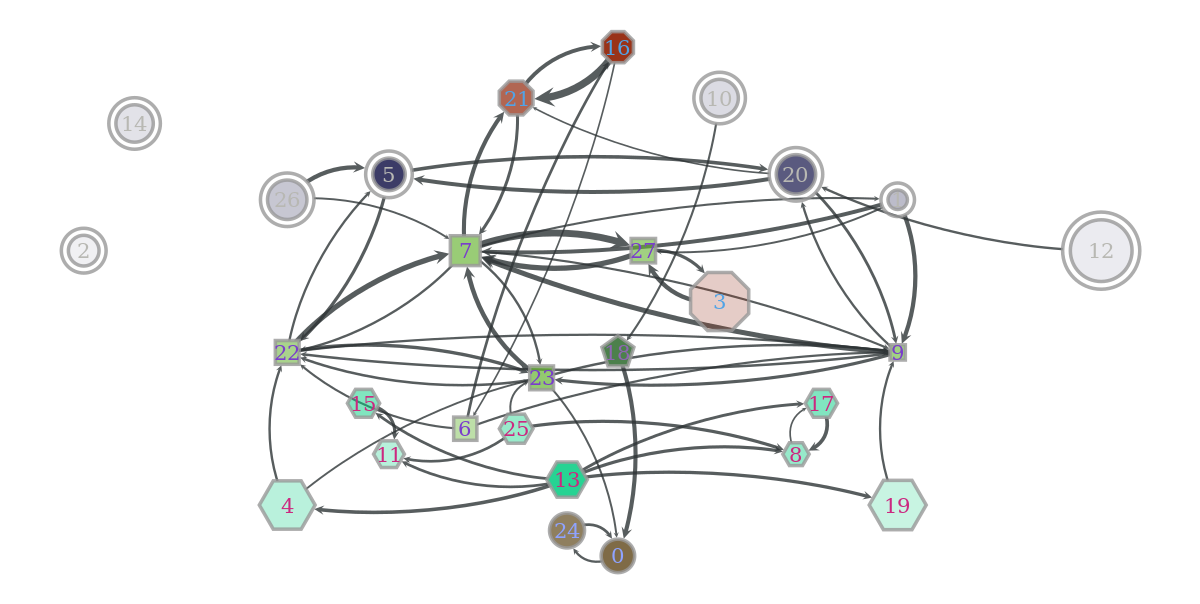

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd3a9db62e8, at 0x7fd3998c3780>

In [1109]:
vlabel = block_g.new_vertex_property("int32_t")
vlabel.a = np.arange(28)
vsize = block_g.new_vertex_property("float")
vsize.a = block_g.vp["size"].a / 100

esyn_th = 0.04
ewith = block_g.new_edge_property("float")
ewith.a = block_g.ep["syn_prob"].a
ewith.a[ewith.a < esyn_th] = 0.0
ewith.a = ewith.a * 20

pos_dict = {
    0: (1,0), 24: (-1,-1),
    3: (5,-10), 16: (1,-20), 21: (-3,-18),
    6: (-5, -5), 7: (-5, -12), 23: (-2, -7), 27: (2, -12),
    22: (-12, -8), 9: (12, -8),
    18: (1, -8),
    ## olfactory:
    13: (-1, -3), 25: (-3, -5),
    4: (-12,-2), 19: (12, -2),
    11: (-8,-4), 8: (8, -4),
    15: (-9,-6), 17: (9, -6),
    ## visual:
    10: (5, -18),
    26: (-12, -14), 1: (12, -14),
    2: (-20, -12), 12: (20, -12),
    5: (-8, -15), 20: (8, -15),
    14: (-18, -17)
}

shape_dict = {
    0: 0, 24: 0,
    3: 6, 16: 6, 21: 6,
    6: 2, 7: 2, 23: 2, 27: 2,
    22: 2, 9: 2,
    18: 3,
    ## olfactory:
    13: 4, 25: 4,
    4: 4, 19: 4,
    11: 4, 8: 4,
    15: 4, 17: 4,
    ## visual:
    10: 7,
    26: 7, 1: 7,
    2: 7, 12: 7,
    5: 7, 20: 7,
    14: 7
}

color_dict = {
    0: [0.3,0.2,0,0.8], 24: [0.3,0.2,0,0.8],
    3: [0.6,0.2,0.1,0.8], 16: [0.6,0.2,0.1,0.8], 21: [0.6,0.2,0.1,0.8],
    6: [0.4,0.7,0.2,0.8], 7: [0.4,0.7,0.2,0.8], 23: [0.4,0.7,0.2,0.8], 27: [0.4,0.7,0.2,0.8],
    22: [0.4,0.7,0.2,0.8], 9: [0.4,0.7,0.2,0.8],
    18: [0.3,0.5,0.3,0.8],
    ## olfactory:
    13: [0.0, 0.8, 0.5,0.8], 25: [0.0, 0.8, 0.5,0.8],
    4: [0.0, 0.8, 0.5,0.8], 19: [0.0, 0.8, 0.5,0.8],
    11: [0.0, 0.8, 0.5,0.8], 8: [0.0, 0.8, 0.5,0.8],
    15: [0.0, 0.8, 0.5,0.8], 17: [0.0, 0.8, 0.5,0.8],
    ## visual:
    10: [0.1,0.1,0.3,0.8],
    26: [0.1,0.1,0.3,0.8], 1: [0.1,0.1,0.3,0.8],
    2: [0.1,0.1,0.3,0.8], 12: [0.1,0.1,0.3,0.8],
    5: [0.1,0.1,0.3,0.8], 20: [0.1,0.1,0.3,0.8],
    14: [0.1,0.1,0.3,0.8]
}

color_density_dict = {k:[color_dict[k][0], color_dict[k][1], 
                       color_dict[k][2], syn_prob[k,k] * 2.5] for k in color_dict.keys()}

pos = block_g.new_vertex_property("vector<double>")
for i, v in enumerate(block_g.vertices()):
    pos[v] = pos_dict[i]
    
vshape = block_g.new_vertex_property("int32_t")
for i, v in enumerate(block_g.vertices()):
    vshape[v] = shape_dict[i]
    
vcolor = block_g.new_vertex_property("vector<double>")
for i, v in enumerate(block_g.vertices()):
    vcolor[v] = color_density_dict[i]
    
vtxtcolor = block_g.new_vertex_property("vector<double>")
for i, v in enumerate(block_g.vertices()):
    vtxtcolor[v] = [color_dict[i][3]*(1-color_dict[i][0]), 
                    color_dict[i][3]*(1-color_dict[i][1]), 
                    (1-color_dict[i][2]), 1]
    
    
gt.graph_draw(block_g, pos=pos, vertex_shape=vshape, vertex_text=vlabel, vertex_text_color=vtxtcolor, 
              vertex_fill_color=vcolor, vertex_size=vsize, edge_pen_width=ewith)

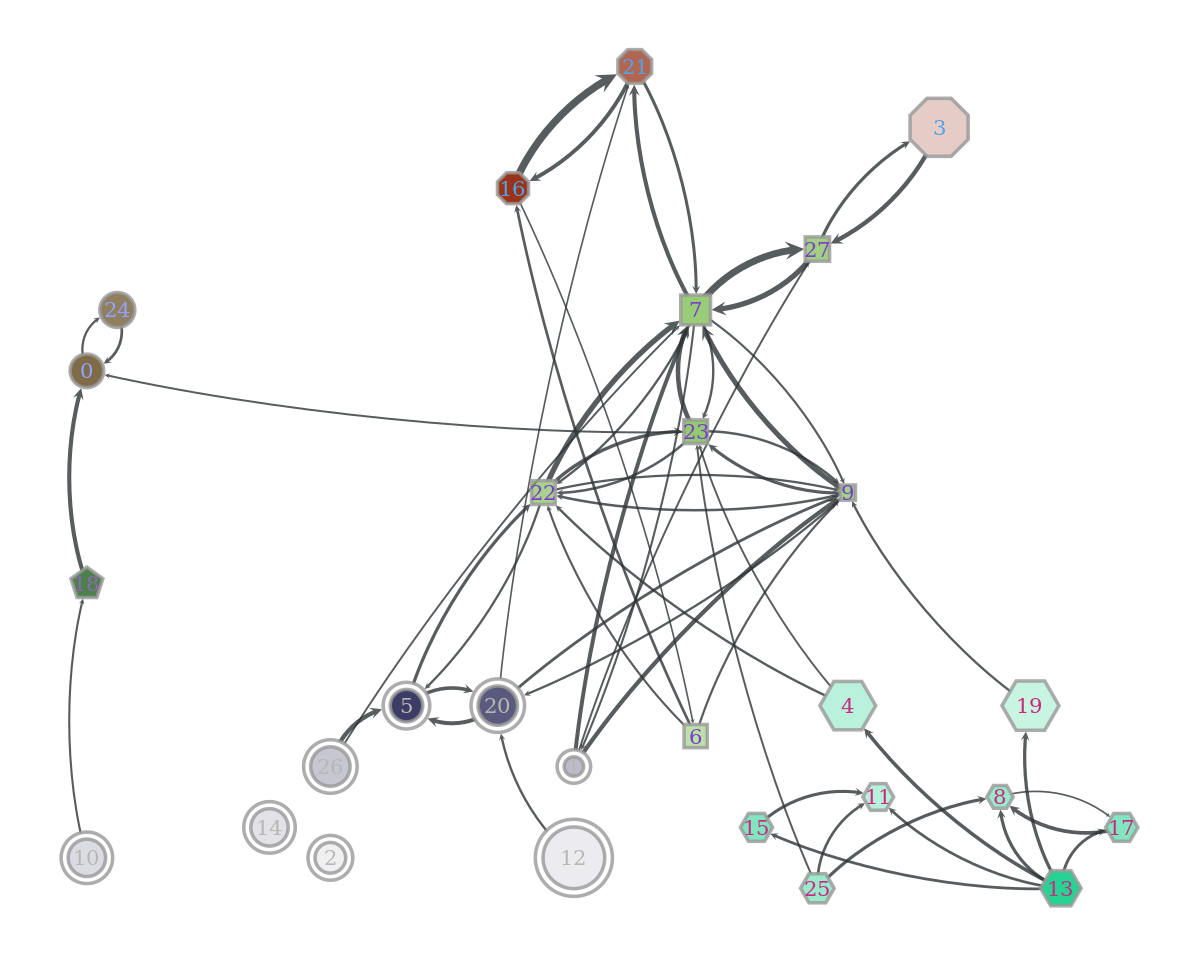

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd3a9db62e8, at 0x7fd3998c0a20>

In [1110]:
vlabel = block_g.new_vertex_property("int32_t")
vlabel.a = np.arange(28)
vsize = block_g.new_vertex_property("float")
vsize.a = block_g.vp["size"].a / 100

esyn_th = 0.04
ewith = block_g.new_edge_property("float")
ewith.a = block_g.ep["syn_prob"].a
ewith.a[ewith.a < esyn_th] = 0.0
ewith.a = ewith.a * 20

pos_dict = {
    0: (-20,-12), 24: (-19,-14),
    3: (8,-20), 16: (-6,-18), 21: (-2,-22),
    6: (0, 0), 7: (0, -14), 23: (0, -10), 27: (4, -16),
    22: (-5, -8), 9: (5, -8),
    18: (-20, -5),
    ## olfactory:
    13: (12, 5), 25: (4, 5),
    4: (5,-1), 19: (11, -1),
    11: (6,2), 8: (10, 2),
    15: (2,3), 17: (14, 3),
    ## visual:
    10: (-20, 4),
    26: (-12, 1), 1: (-4, 1),
    2: (-12, 4), 12: (-4, 4),
    5: (-9.5, -1), 20: (-6.5, -1),
    14: (-14, 3)
}

shape_dict = {
    0: 0, 24: 0,
    3: 6, 16: 6, 21: 6,
    6: 2, 7: 2, 23: 2, 27: 2,
    22: 2, 9: 2,
    18: 3,
    ## olfactory:
    13: 4, 25: 4,
    4: 4, 19: 4,
    11: 4, 8: 4,
    15: 4, 17: 4,
    ## visual:
    10: 7,
    26: 7, 1: 7,
    2: 7, 12: 7,
    5: 7, 20: 7,
    14: 7
}

color_dict = {
    0: [0.3,0.2,0,0.8], 24: [0.3,0.2,0,0.8],
    3: [0.6,0.2,0.1,0.8], 16: [0.6,0.2,0.1,0.8], 21: [0.6,0.2,0.1,0.8],
    6: [0.4,0.7,0.2,0.8], 7: [0.4,0.7,0.2,0.8], 23: [0.4,0.7,0.2,0.8], 27: [0.4,0.7,0.2,0.8],
    22: [0.4,0.7,0.2,0.8], 9: [0.4,0.7,0.2,0.8],
    18: [0.3,0.5,0.3,0.8],
    ## olfactory:
    13: [0.0, 0.8, 0.5,0.8], 25: [0.0, 0.8, 0.5,0.8],
    4: [0.0, 0.8, 0.5,0.8], 19: [0.0, 0.8, 0.5,0.8],
    11: [0.0, 0.8, 0.5,0.8], 8: [0.0, 0.8, 0.5,0.8],
    15: [0.0, 0.8, 0.5,0.8], 17: [0.0, 0.8, 0.5,0.8],
    ## visual:
    10: [0.1,0.1,0.3,0.8],
    26: [0.1,0.1,0.3,0.8], 1: [0.1,0.1,0.3,0.8],
    2: [0.1,0.1,0.3,0.8], 12: [0.1,0.1,0.3,0.8],
    5: [0.1,0.1,0.3,0.8], 20: [0.1,0.1,0.3,0.8],
    14: [0.1,0.1,0.3,0.8]
}

color_density_dict = {k:[color_dict[k][0], color_dict[k][1], 
                       color_dict[k][2], syn_prob[k,k] * 2.5] for k in color_dict.keys()}

pos = block_g.new_vertex_property("vector<double>")
for i, v in enumerate(block_g.vertices()):
    pos[v] = pos_dict[i]
    
vshape = block_g.new_vertex_property("int32_t")
for i, v in enumerate(block_g.vertices()):
    vshape[v] = shape_dict[i]
    
vcolor = block_g.new_vertex_property("vector<double>")
for i, v in enumerate(block_g.vertices()):
    vcolor[v] = color_density_dict[i]
    
vtxtcolor = block_g.new_vertex_property("vector<double>")
for i, v in enumerate(block_g.vertices()):
    vtxtcolor[v] = [color_dict[i][3]*(1-color_dict[i][0]), 
                    color_dict[i][3]*(1-color_dict[i][1]), 
                    (1-color_dict[i][2]), 1]
    
    
gt.graph_draw(block_g, pos=pos, vertex_shape=vshape, vertex_text=vlabel, vertex_text_color=vtxtcolor, 
              vertex_fill_color=vcolor, vertex_size=vsize, edge_pen_width=ewith)

In [904]:
[cid2nid[i] in mod_vs[3] for i in top10leastvisited]

[True, True, True, True, True, True, False, True, True, True]

In [905]:
[cid2nid[i] in mod_vs[20] for i in top10leastvisited]

[False, False, False, False, False, False, True, False, False, False]

In [919]:
# test membership of certain neurons
LtoR = [720575940607234571, 720575940616450305, 720575940620012253,
       720575940620541823, 720575940625428873, 720575940628519415]
RtoL = [720575940615526289, 720575940615947993, 720575940625066904,
       720575940626576489, 720575940632331289]

# [(j, [cid2nid[i] in mod_vs[j] for i in LtoR]) for j in range(28)]
# not in any of the above modules

# [(j,[cid2nid[i] in mod_vs[j] for i in RtoL]) for j in range(28)]
# module 

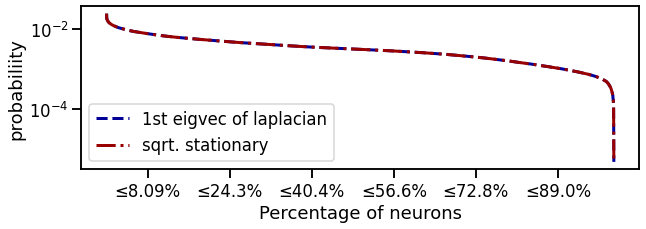

In [935]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(np.sort(L_chung_eigvec[:,0])[::-1], linewidth=3, linestyle='--', color=(0.0,0,0.6), label="1st eigvec of laplacian")
ax.plot(np.sqrt(np.sort(p_stationary)[::-1]), linewidth=3, linestyle='-.', color=(0.6,0,0), label="sqrt. stationary")
ax.set_yscale('log')
ax.set_xticks(np.arange(4000, scc_g.num_vertices(), 8000))
ax.set_xticklabels(["≤{:.3}%".format(100*i) for i in (np.arange(4000, scc_g.num_vertices(), 8000)+1)/scc_g.num_vertices()])
ax.legend()
ax.set_ylabel("probabiliity")
ax.set_xlabel("Percentage of neurons")
plt.show()

#### 2.1.6 Peripheral neurons

In [943]:
%%time
peripheral_neurons = [n for n in wcc_g.get_vertices() if n not in scc_g.get_vertices()]

CPU times: user 15.8 s, sys: 240 ms, total: 16.1 s
Wall time: 16.1 s


In [1021]:
len(peripheral_neurons)

503

In [980]:
peripheral_in_neurons = np.array(peripheral_neurons)[g.get_out_degrees(peripheral_neurons) > 0]
peripheral_out_neurons = np.array(peripheral_neurons)[g.get_in_degrees(peripheral_neurons) > 0]

In [981]:
# number of in-neurons, out-neurons and neurons with both in and out (island)..
len(peripheral_in_neurons), len(peripheral_out_neurons), len(np.intersect1d(peripheral_in_neurons, peripheral_out_neurons))

(172, 348, 17)

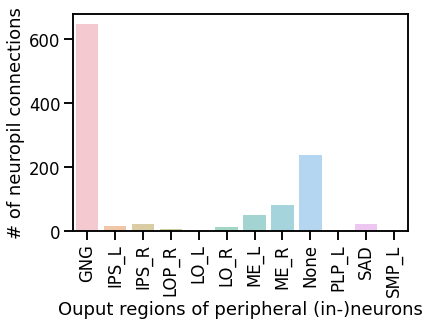

In [982]:
# input regions of this peripheral in-neurons
reg_in, reg_in_cnt = np.unique(syn_table[syn_table["pre_nid"].isin(peripheral_in_neurons)]["neuropil"], 
                               return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(reg_in, reg_in_cnt, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Ouput regions of peripheral (in-)neurons")
plt.show()

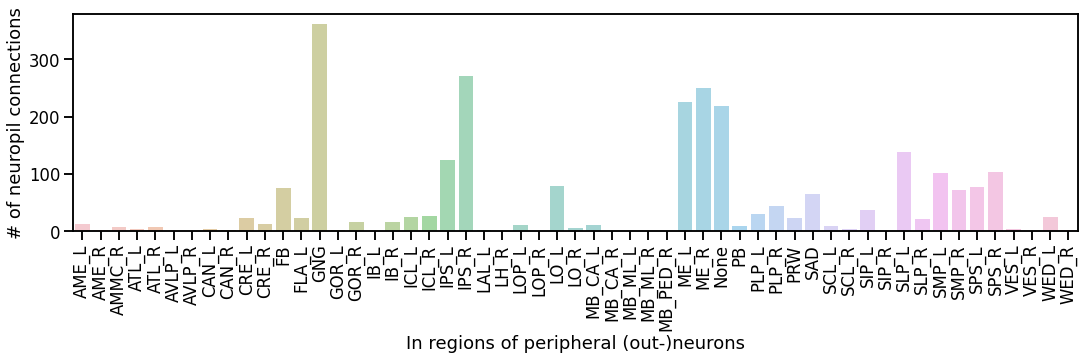

In [985]:
# input regions of this peripheral out-neurons
reg_out, reg_out_cnt = np.unique(syn_table[syn_table["post_nid"].isin(peripheral_out_neurons)]["neuropil"], 
                                 return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(18,4))
sns.barplot(reg_out, reg_out_cnt, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("In regions of peripheral (out-)neurons")
plt.show()

In [1048]:
sensor_in = np.unique(syn_table[syn_table["pre_nid"].isin(peripheral_in_neurons) & (syn_table["neuropil"] == 'GNG')]["pre_nid"].values)
post_sensor_in = np.unique(syn_table[syn_table["pre_nid"].isin(sensor_in) & (syn_table["neuropil"] == 'GNG')]["post_nid"].values)
len(sensor_in)

77

In [1049]:
len(np.intersect1d(post_sensor_in, peripheral_neurons)), len(post_sensor_in)

(8, 447)

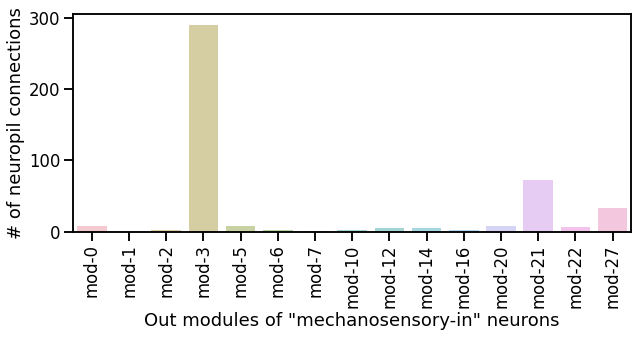

In [1051]:
# None of this neurons directly receive from a module
mod_in, mod_in_cnt = np.unique([np.arange(28)[np.array([(i in mod_vs[j]) for j in range(28)])].sum() 
                                  for i in post_sensor_in], return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(10,4))
sns.barplot(["mod-{}".format(m) for m in mod_in], mod_in_cnt, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel('Out modules of "mechanosensory-in" neurons')
plt.show()

In [1256]:
vision_in_L = np.unique(syn_table[syn_table["pre_nid"].isin(peripheral_in_neurons) & (syn_table["neuropil"] == 'ME_L')]["pre_nid"].values)
post_vision_in_L = np.unique(syn_table[syn_table["pre_nid"].isin(vision_in_L) & (syn_table["neuropil"] == 'ME_L')]["post_nid"].values)
len(vision_in_L)

16

In [1257]:
vis_link([nid2cid[i] for i in vision_in_L])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

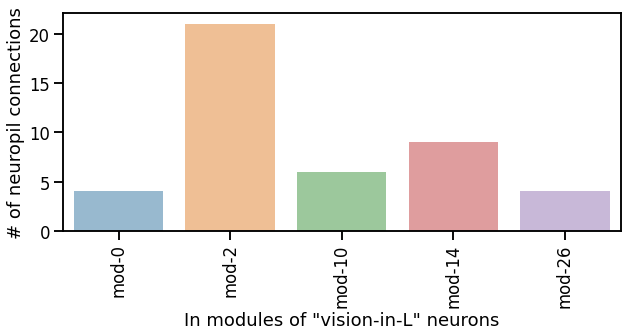

In [1258]:
# None of this neurons directly receive from a module
mod_out, mod_out_cnt = np.unique([np.arange(28)[np.array([(i in mod_vs[j]) for j in range(28)])].sum() 
                                  for i in post_vision_in_L], return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(10,4))
sns.barplot(["mod-{}".format(m) for m in mod_out], mod_out_cnt, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel('In modules of "vision-in-L" neurons')
plt.show()

In [1263]:
vision_in_R = np.unique(syn_table[syn_table["pre_nid"].isin(peripheral_in_neurons) & (syn_table["neuropil"] == 'ME_R')]["pre_nid"].values)
post_vision_in_R = np.unique(syn_table[syn_table["pre_nid"].isin(vision_in_R) & (syn_table["neuropil"] == 'ME_R')]["post_nid"].values)
len(vision_in_R)

28

In [1264]:
vis_link([nid2cid[i] for i in vision_in_R])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

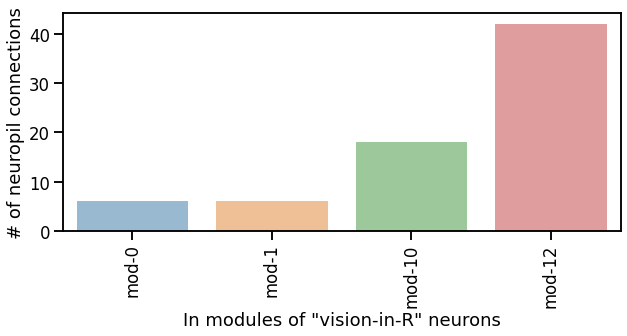

In [1265]:
# None of this neurons directly receive from a module
mod_out, mod_out_cnt = np.unique([np.arange(28)[np.array([(i in mod_vs[j]) for j in range(28)])].sum() 
                                  for i in post_vision_in_R], return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(10,4))
sns.barplot(["mod-{}".format(m) for m in mod_out], mod_out_cnt, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel('In modules of "vision-in-R" neurons')
plt.show()

In [1045]:
motor_out = np.unique(syn_table[syn_table["post_nid"].isin(peripheral_out_neurons) & (syn_table["neuropil"] == 'GNG')]["post_nid"].values)
pre_motor_out = np.unique(syn_table[syn_table["post_nid"].isin(motor_out) & (syn_table["neuropil"] == 'GNG')]["pre_nid"].values)
len(motor_out)

67

In [1046]:
len(np.intersect1d(pre_motor_out, peripheral_neurons)), len(pre_motor_out)

(8, 315)

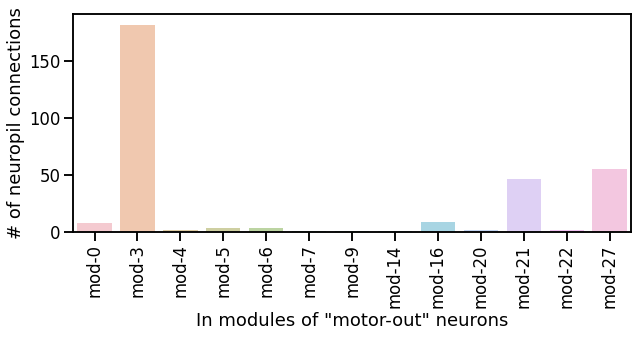

In [1052]:
# None of this neurons directly receive from a module
mod_out, mod_out_cnt = np.unique([np.arange(28)[np.array([(i in mod_vs[j]) for j in range(28)])].sum() 
                                  for i in pre_motor_out], return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(10,4))
sns.barplot(["mod-{}".format(m) for m in mod_out], mod_out_cnt, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel('In modules of "motor-out" neurons')
plt.show()

In [1053]:
vis_link([nid2cid[i] for i in motor_out])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

#### 2.1.7 Example pathways

In [1273]:
len(vision_in_L), len(mod_vs[16])

(16, 1020)

In [1274]:
inverse_syn_count = g.new_edge_property("float")
inverse_syn_count.a = 1/g.ep["syn_count"].a

In [1275]:
of_s = np.random.choice(vision_in_L) # from vision
mo_t = np.random.choice(mod_vs[16]) # to motor

vision2motor_path = gt.shortest_path(g, source=of_s, target=mo_t, weights=inverse_syn_count)

In [1415]:
# vision2motor_path

In [1277]:
[g.ep["syn_count"][e] for e in vision2motor_path[1]]

[2, 17, 26, 153, 68, 186, 134, 263, 97, 283, 93, 182, 78, 17]

In [1278]:
[np.arange(28)[np.array([(i in mod_vs[j]) for j in range(28)])].sum() for i in vision2motor_path[0]]

[0, 2, 26, 5, 2, 2, 1, 1, 9, 6, 6, 6, 6, 6, 16]

In [1416]:
# [nid2cid[i] for i in vision2motor_path[0]]

In [1280]:
vis_link([nid2cid[i] for i in vision2motor_path[0]])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

In [1396]:
### manunally find a stong visual pathway

lamina2medula = syn_table[syn_table["pre_nid"].isin(vision_in_L)]

medula2lobula = syn_table[syn_table["pre_nid"].isin(lamina2medula["post_nid"]) 
                & (~syn_table["post_nid"].isin(vision_in_L))
                & (syn_table["neuropil"].isin(['LO_L']))]

lobula2lobula_plate = syn_table[syn_table["pre_nid"].isin(medula2lobula["post_nid"]) 
                & (~syn_table["post_nid"].isin(medula2lobula["pre_nid"]))
                & (syn_table["neuropil"].isin(['LOP_L']))]

In [1417]:
syn_th = 4
lobula_candidates = np.intersect1d(medula2lobula[medula2lobula["syn_count"] > syn_th]["post_nid"],
                          lobula2lobula_plate[lobula2lobula_plate["syn_count"] > syn_th]["pre_nid"])
# print(lobula_candidates)
medula_candidates = np.intersect1d(medula2lobula[(medula2lobula["syn_count"] > syn_th) 
                                                 & medula2lobula["post_nid"].isin(lobula_candidates)]["pre_nid"],
                                   lamina2medula[lamina2medula["syn_count"] > syn_th]["post_nid"])
# print(medula_candidates)
lamina_candidates = np.array(lamina2medula[lamina2medula["post_nid"].isin(medula_candidates)]["pre_nid"])
# print(lamina_candidates)

In [1418]:
medula2lobula[medula2lobula["pre_nid"].isin(medula_candidates) 
              & medula2lobula["post_nid"].isin(lobula_candidates)]

lobula2lobula_plate[lobula2lobula_plate["pre_nid"].isin([33617]) 
              & (lobula2lobula_plate["syn_count"] > syn_th)]

pre_pt_root_id     post_pt_root_id neuropil  syn_count  pre_nid  \
1606562  720575940627939431  720575940619309294    LOP_L          5    33617   

         post_nid  
1606562     16818

In [1426]:
# syn_table[syn_table["pre_nid"].isin([16818]) & (syn_table["syn_count"]>20)]

In [1428]:
vis_link([nid2cid[i] for i in [25132, 49934, 33617, 16818]])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

In [1427]:
[nid2cid[i] for i in [25132, 49934, 33617, 16818]]

[720575940623511532,
 720575940658774657,
 720575940627939431,
 720575940619309294]

In [1444]:
syn_table[(syn_table["post_nid"]==33617) 
          & (syn_table["neuropil"].isin(["ME_L"]))
         & (syn_table["syn_count"] >= 5)]["pre_pt_root_id"].values

array([720575940638702168, 720575940635197541, 720575940628364414])

---

#### 2.2 Co-Clustering and Quantifying Asymmetry with a Laplacian defined by Rohe, Qin, & Yu

The regularized graph Laplacian $L \in \mathbb R^{n\times n}$ is defined as
$$L^{\tau}_{ij} = \frac{A_{ij}}{\sqrt{[D_{+}^{\tau}]_{ii}[D_{-}^{\tau}]_{jj}}} = \left[(D_+^{\tau})^{-1/2}A(D_-^{\tau})^{-1/2}\right]_{ij}$$
where
$[D_{+}^{\tau}]_{ij} = \delta_{ij} \left(\sum_{k}A_{ik} + \tau\right)$ is the in-degree matrix, and $[D_{-}^{\tau}]_{ij} = \delta_{ij} \left(\sum_{k}A_{kj} + \tau\right)$ is the out-degree matrix.

Their method is based on the singular value decomposition of this Laplacian.

In [422]:
# constructing "regularized graph laplacian"
# as in Rohe, Qin, & Yu 2016

def rqy_laplacian(A, g_, tau=0):
    A_coo = scipy.sparse.coo_matrix(A)
    in_degrees = g_.get_in_degrees(g_.get_vertices())
    out_degrees = g_.get_out_degrees(g_.get_vertices())

    reg_laplacian_v = []
    reg_laplacian_row = []
    reg_laplacian_col = []
    for i, j, a in zip(A_coo.row, A_coo.col, A_coo.data):
        reg = np.sqrt((in_degrees[i] + tau) * (out_degrees[j] + tau))
        reg_laplacian_v.append(a/reg)
        reg_laplacian_row.append(i)
        reg_laplacian_col.append(j)

    L_tau = scipy.sparse.coo_matrix((reg_laplacian_v, (reg_laplacian_row, reg_laplacian_col)), 
                                     shape=(wcc_g.num_vertices(), wcc_g.num_vertices()))
    
    return L_tau

In [423]:
%%time
L_tau = rqy_laplacian(A_w, wcc_g, tau=0)

CPU times: user 31.2 s, sys: 1.38 s, total: 32.5 s
Wall time: 32.6 s


In [424]:
%%time
from scipy.sparse import linalg as SLA
Lsigvec_l, Lsigval, Lsigvec_rh = SLA.svds(L_tau, k=100, which='LM')

CPU times: user 3min 36s, sys: 2min 40s, total: 6min 17s
Wall time: 38.1 s


In [425]:
# the order of returned sigular values is not guaranteed
ind_order = np.argsort(Lsigval)[::-1]

In [426]:
Lsigvec_l = Lsigvec_l[:,ind_order]
Lsigval = Lsigval[ind_order]
Lsigvec_r = Lsigvec_rh[ind_order].T

In [457]:
# gap more than 1% bi-connections
Lsigval_gaps = np.arange(1, 100)[np.diff(Lsigval) < -0.01]
Lsigval_gaps

array([ 4,  5,  6,  7, 10, 23])

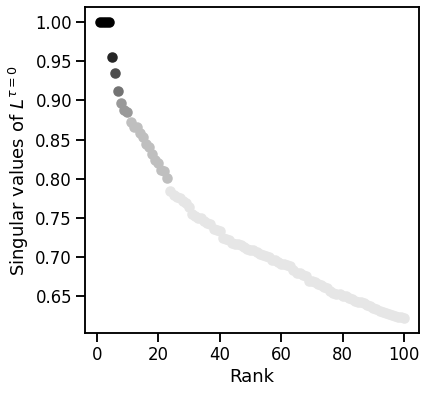

In [767]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
gap_prev = 0
alphas = np.linspace(0,0.9,len(Lsigval_gaps)+1)
for i, gap in enumerate(Lsigval_gaps):
    ax.scatter(range(gap_prev+1,gap+1), np.abs(Lsigval[gap_prev:gap]), color=[alphas[i]]*3)
    gap_prev = gap
ax.scatter(range(gap_prev+1,101), np.abs(Lsigval[gap_prev:]), color=[alphas[-1]]*3)
ax.set_ylabel("Singular values of $L^{τ=0}$")
ax.set_xlabel("Rank")
plt.show()

Text(0.5, 0, 'Rank')

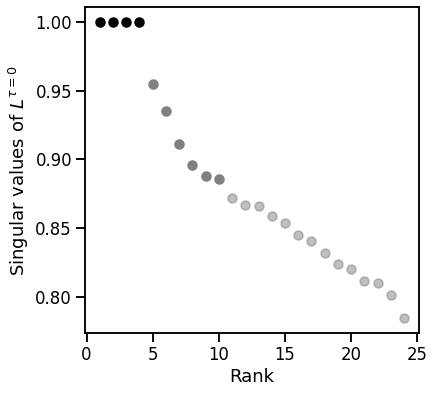

In [769]:
# I think this mesures the size of cut 
# by the number of bidirectional connections

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(range(1,5), np.abs(Lsigval[:4]), color='black')
ax.scatter(range(5,11), np.abs(Lsigval[4:10]), color='gray')
ax.scatter(range(11,25), np.abs(Lsigval[10:24]), color='gray', alpha=0.5)
# ax.scatter(range(11,21), np.abs(Lsigval[10:20]), color='gray', alpha=0.2)
ax.set_ylabel("Singular values of $L^{τ=0}$")
ax.set_xlabel("Rank")

In [789]:
# trisect the brain via 2nd and 3rd eigenvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
neu_rep_sig = normalize(Lsigvec_l[:,:4])
kmean = KMeans(n_clusters=4).fit(np.real(neu_rep_sig))
b4_receving_groups = kmean.labels_

# the right sigular vector contains zeros..
neu_rep_sig = np.nan_to_num(normalize(Lsigvec_r[:,:4]))
kmean = KMeans(n_clusters=4).fit(np.real(neu_rep_sig))
b4_sending_groups = kmean.labels_

In [788]:
%%time
wcc_g_b4_receiving = block_graph(wcc_g, b4_receving_groups)
wcc_g_b4_sending = block_graph(wcc_g, b4_sending_groups)

CPU times: user 4.91 s, sys: 84 ms, total: 5 s
Wall time: 3.62 s


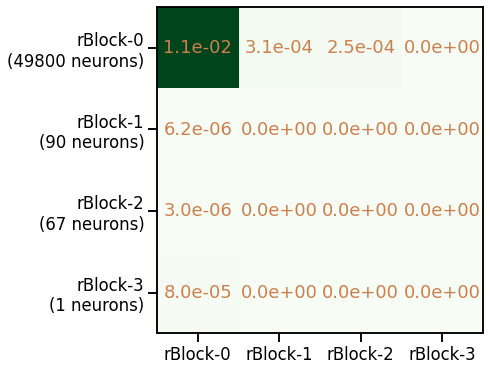

In [796]:
block_sizes, syn_prob = summarize_block(wcc_g_b4_receiving, norm=True)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(syn_prob, 'Greens')
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, "{:.1e}".format(syn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(4))
ax.set_xticklabels(["rBlock-{}".format(i) for i, s in enumerate(block_sizes)])
ax.set_yticks(range(4))
ax.set_yticklabels(["rBlock-{}\n({} neurons)".format(i, s) for i, s in enumerate(block_sizes)])
plt.show()

In [799]:
[nid2cid[x] for x in wcc_g.get_vertices()[b4_receving_groups==3]]

[720575940623010795]

In [802]:
syn_table[syn_table["pre_pt_root_id"]==720575940624661029]

pre_pt_root_id     post_pt_root_id neuropil  syn_count  pre_nid  \
2032735  720575940624661029  720575940623010795     ME_R          4    26862   

         post_nid  
2032735     24230

In [808]:
%%time
L_tau = rqy_laplacian(A_w, wcc_g, tau=A_w.sum()/wcc_g.num_vertices())

CPU times: user 29 s, sys: 536 ms, total: 29.5 s
Wall time: 30 s


In [809]:
%%time
from scipy.sparse import linalg as SLA
Lsigvec_l, Lsigval, Lsigvec_rh = SLA.svds(L_tau, k=100, which='LM')

CPU times: user 2min 33s, sys: 1min 57s, total: 4min 31s
Wall time: 28.9 s


In [810]:
# the order of returned sigular values is not guaranteed
ind_order = np.argsort(Lsigval)[::-1]

In [811]:
Lsigvec_l = Lsigvec_l[:,ind_order]
Lsigval = Lsigval[ind_order]
Lsigvec_r = Lsigvec_rh[ind_order].T

In [812]:
# gap more than 1% bi-connections
Lsigval_gaps = np.arange(1, 100)[np.diff(Lsigval) < -0.01]
Lsigval_gaps

array([ 1,  2,  4,  5, 10, 12, 14, 23])

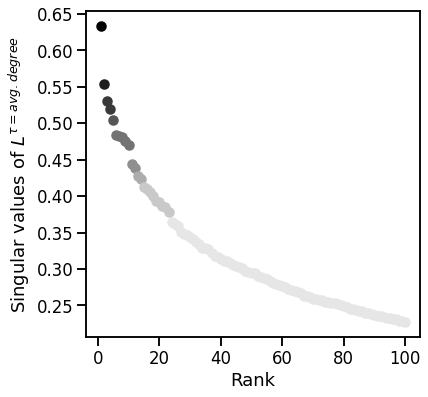

In [813]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
gap_prev = 0
alphas = np.linspace(0,0.9,len(Lsigval_gaps)+1)
for i, gap in enumerate(Lsigval_gaps):
    ax.scatter(range(gap_prev+1,gap+1), np.abs(Lsigval[gap_prev:gap]), color=[alphas[i]]*3)
    gap_prev = gap
ax.scatter(range(gap_prev+1,101), np.abs(Lsigval[gap_prev:]), color=[alphas[-1]]*3)
ax.set_ylabel("Singular values of $L^{τ=avg. degree}$")
ax.set_xlabel("Rank")
plt.show()

Text(0.5, 0, 'Rank')

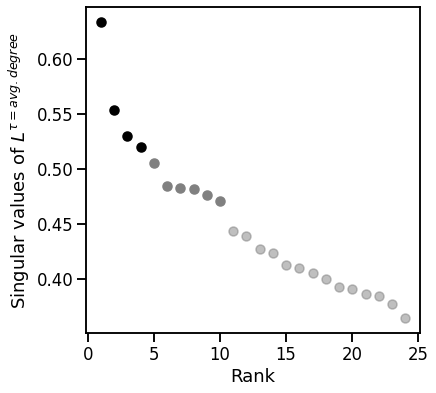

In [815]:
# I think this mesures the size of cut 
# by the number of bidirectional connections

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(range(1,5), np.abs(Lsigval[:4]), color='black')
ax.scatter(range(5,11), np.abs(Lsigval[4:10]), color='gray')
ax.scatter(range(11,25), np.abs(Lsigval[10:24]), color='gray', alpha=0.5)
# ax.scatter(range(11,21), np.abs(Lsigval[10:20]), color='gray', alpha=0.2)
ax.set_ylabel("Singular values of $L^{τ=avg. degree}$")
ax.set_xlabel("Rank")

In [817]:
# trisect the brain via 2nd and 3rd eigenvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
neu_rep_sig = normalize(Lsigvec_l[:,:5])
kmean = KMeans(n_clusters=5).fit(np.real(neu_rep_sig))
b5_receiving_groups = kmean.labels_

# the right sigular vector contains zeros..
neu_rep_sig = np.nan_to_num(normalize(Lsigvec_r[:,:5]))
kmean = KMeans(n_clusters=5).fit(np.real(neu_rep_sig))
b5_sending_groups = kmean.labels_

In [818]:
%%time
wcc_g_b5_receiving = block_graph(wcc_g, b5_receiving_groups)
wcc_g_b5_sending = block_graph(wcc_g, b5_sending_groups)

CPU times: user 4.63 s, sys: 152 ms, total: 4.78 s
Wall time: 3.64 s


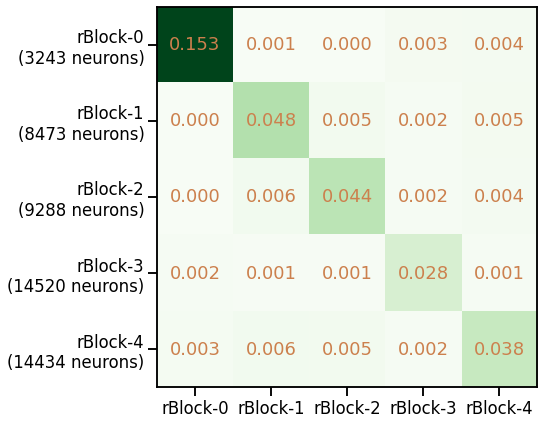

In [1160]:
rblock_sizes, rsyn_prob = summarize_block(wcc_g_b5_receiving, norm=True)

fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(rsyn_prob, 'Greens')
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, "{:.3f}".format(rsyn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(5))
ax.set_xticklabels(["rBlock-{}".format(i) for i, s in enumerate(rblock_sizes)])
ax.set_yticks(range(5))
ax.set_yticklabels(["rBlock-{}\n({} neurons)".format(i, s) for i, s in enumerate(rblock_sizes)])
plt.show()

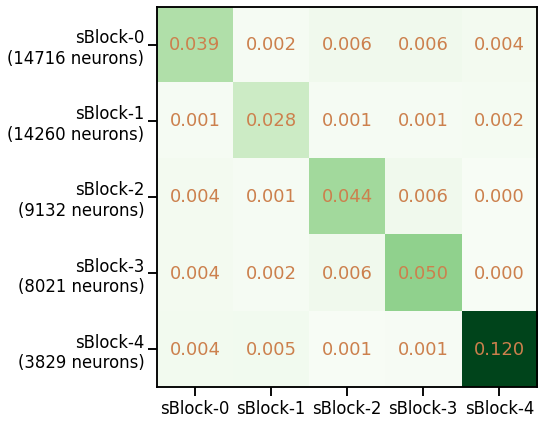

In [1161]:
sblock_sizes, ssyn_prob = summarize_block(wcc_g_b5_sending, norm=True)

fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(ssyn_prob, 'Greens')
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, "{:.3f}".format(ssyn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(5))
ax.set_xticklabels(["sBlock-{}".format(i) for i, s in enumerate(sblock_sizes)])
ax.set_yticks(range(5))
ax.set_yticklabels(["sBlock-{}\n({} neurons)".format(i, s) for i, s in enumerate(sblock_sizes)])
plt.show()

In [834]:
rqy_cls = [b5_receiving_groups, b5_sending_groups]
total_num_block = 0
source, target, value = [], [], []

# recursive flatten
flatten = lambda a:[element for item in a for element in flatten(item)] if type(a) is list else [a]

label = flatten([["{}-{}".format(i,j) for j in range(5)] for i in ['rBlock', 'sBlock']])


stmp, ttmp, vtmp = get_stv(rqy_cls[0], rqy_cls[1] + 5)

source = source + stmp
target = target + ttmp
value = value + vtmp

In [835]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)

In [836]:
fig = go.Figure(data)
fig.write_html('figures/sankey-rqy-cls.html')
display(IFrame('figures/sankey-rqy-cls.html', width=900, height=600))

In [1153]:
rblock_ns = {b: wcc_g.get_vertices()[b5_receiving_groups==b] for b in range(5)}
sblock_ns = {b: wcc_g.get_vertices()[b5_sending_groups==b] for b in range(5)}

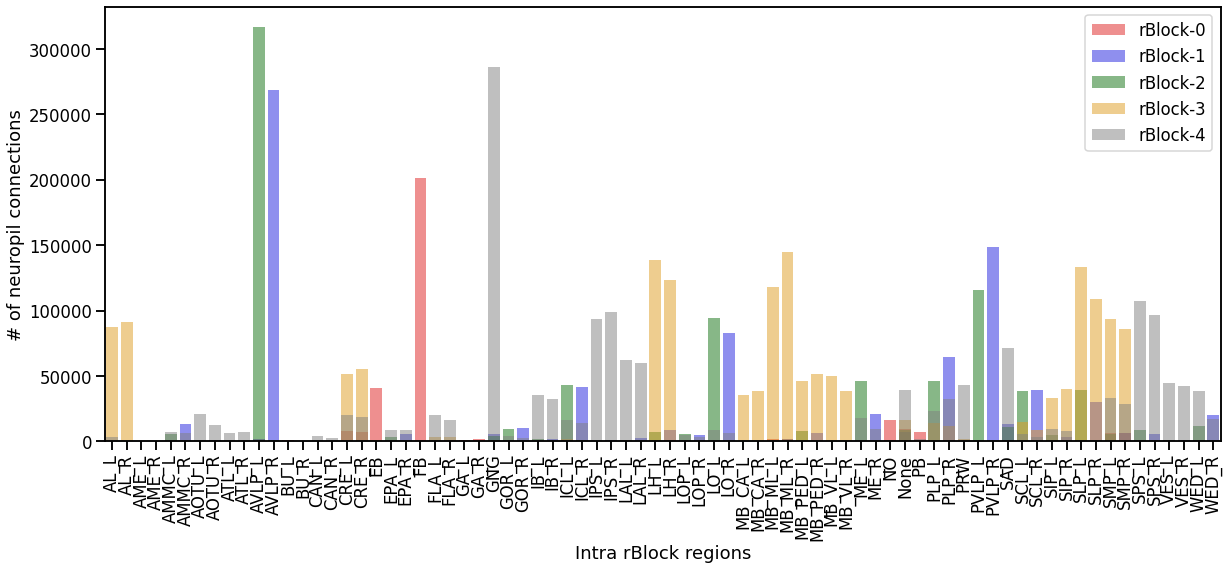

In [1152]:
reg_intra, reg_intra_cnt = {}, {}
colors = ['red', 'blue','green','orange','gray']

for b in range(5):
    reg_intra[b], reg_intra_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(rblock_ns[b])
                                                             & syn_table["post_nid"].isin(rblock_ns[b])], 
                                       return_counts=True)
from functools import reduce
all_reg_intra = reduce(np.union1d, (reg_intra.values()))
intra_reg_dicts = [{k:reg_intra_cnt[b][i] for i, k in enumerate(reg_intra[b])} for b in range(5)]
for b in range(5):
    for reg in all_reg_intra:
        if reg not in intra_reg_dicts[b].keys():
            intra_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(5):
    sns.barplot(all_reg_intra, 
                list(intra_reg_dicts[b][reg] for reg in all_reg_intra), color=colors[b], alpha=0.5, label='rBlock-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra rBlock regions")
ax.legend()
plt.show()

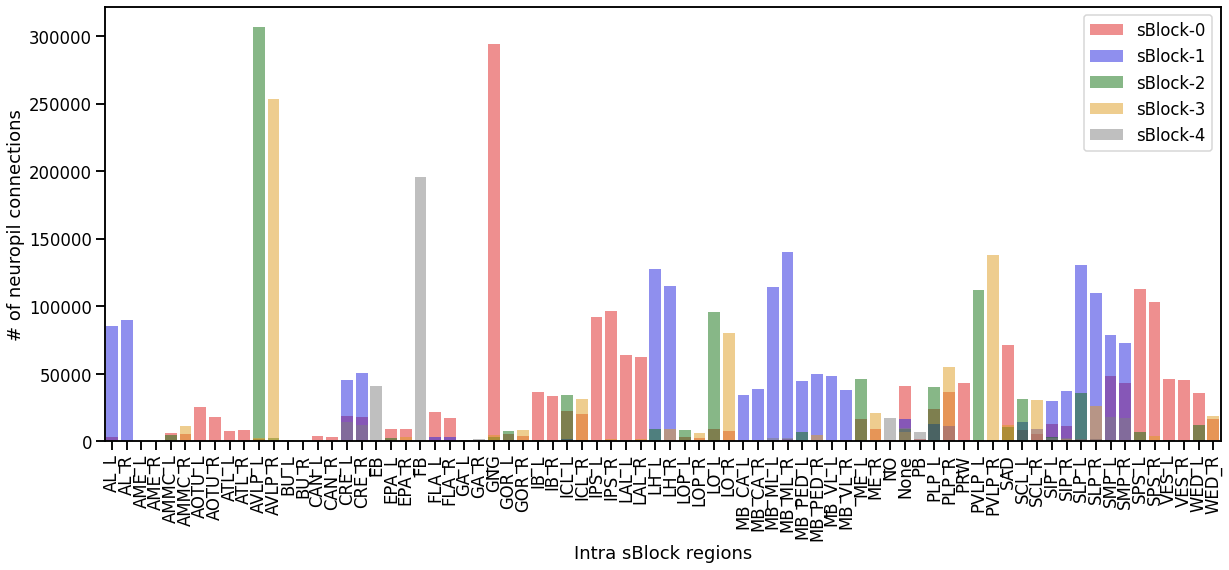

In [1155]:
reg_intra, reg_intra_cnt = {}, {}
colors = ['red', 'blue','green','orange','gray']

for b in range(5):
    reg_intra[b], reg_intra_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(sblock_ns[b])
                                                             & syn_table["post_nid"].isin(sblock_ns[b])], 
                                       return_counts=True)
from functools import reduce
all_reg_intra = reduce(np.union1d, (reg_intra.values()))
intra_reg_dicts = [{k:reg_intra_cnt[b][i] for i, k in enumerate(reg_intra[b])} for b in range(5)]
for b in range(5):
    for reg in all_reg_intra:
        if reg not in intra_reg_dicts[b].keys():
            intra_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(5):
    sns.barplot(all_reg_intra, 
                list(intra_reg_dicts[b][reg] for reg in all_reg_intra), color=colors[b], alpha=0.5, label='sBlock-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra sBlock regions")
ax.legend()
plt.show()

In [1157]:
rblock_g = wcc_g_b5_receiving.get_bg().copy()

In [1158]:
node_size = rblock_g.new_vertex_property("int32_t")
for v in rblock_g.vertices():
    node_size[v] = wcc_g_b5_receiving.get_nr()[v]
rblock_g.vp["size"] = node_size

In [1162]:
node_density = rblock_g.new_vertex_property("float")
for i, v in enumerate(rblock_g.vertices()):
    node_density[v] = rsyn_prob[i,i]
rblock_g.vp["density"] = node_density

In [1164]:
p_syn = rblock_g.new_edge_property("float")
for e in rblock_g.edges():
    if e.source() == e.target():
        # remove self-loops
        p_syn[e] == 0
    else:
        p_syn[e] = wcc_g_b5_receiving.get_ers()[e] / (wcc_g_b5_receiving.get_nr()[e.target()] 
                                             * wcc_g_b5_receiving.get_nr()[e.source()])
rblock_g.ep["syn_prob"] = p_syn

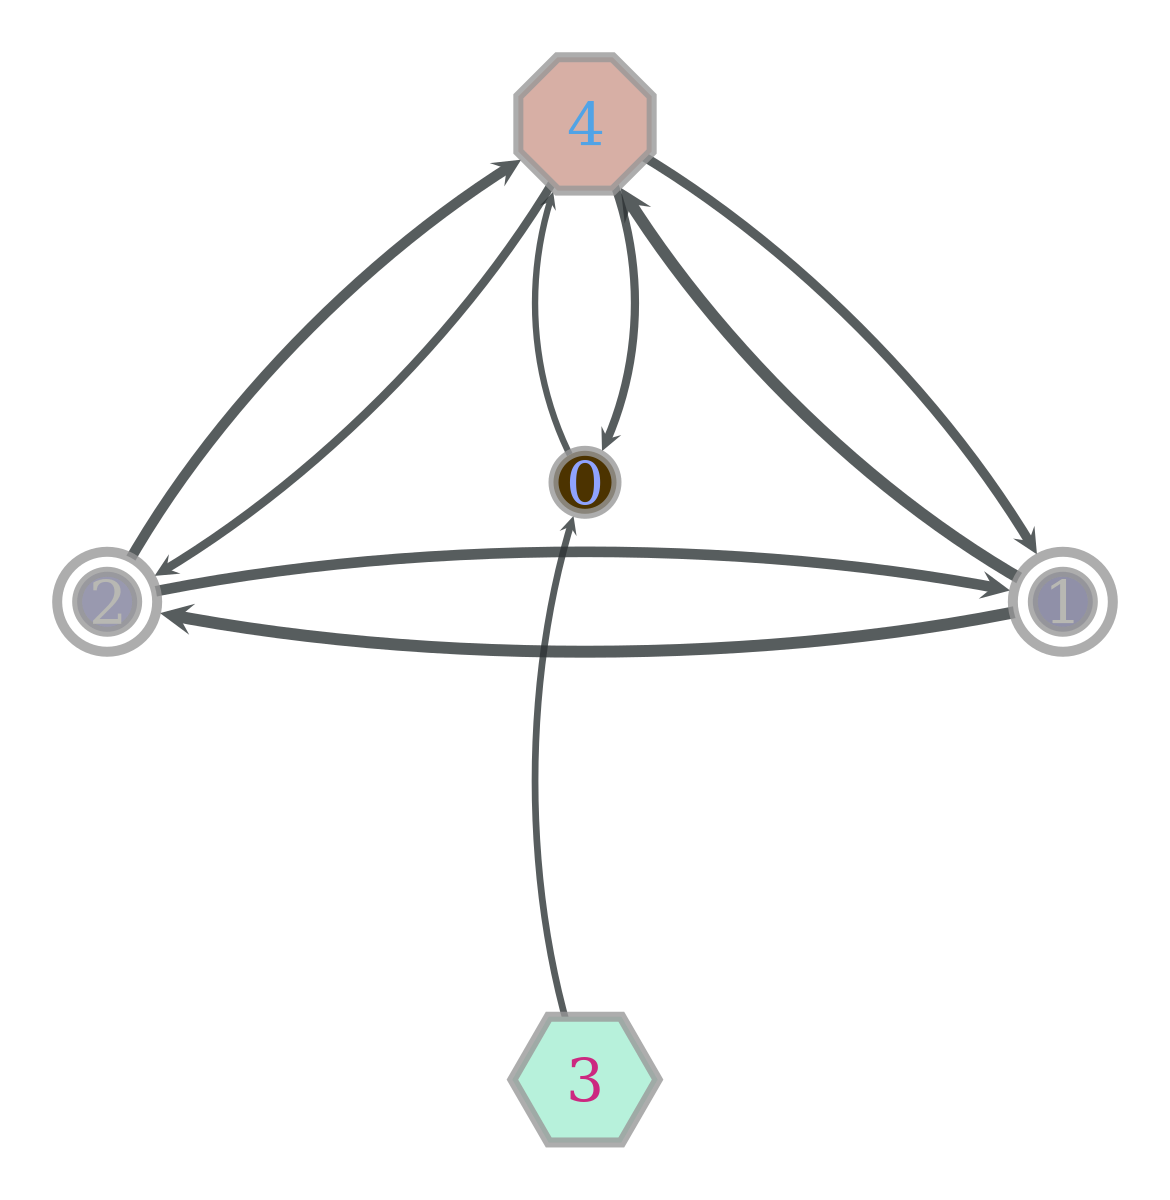

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd3b03c5400, at 0x7fd3b19a2ac8>

In [1207]:
vlabel = rblock_g.new_vertex_property("int32_t")
vlabel.a = np.arange(5)
vsize = rblock_g.new_vertex_property("float")
vsize.a = rblock_g.vp["size"].a / 200

esyn_th = 0.002
ewith = rblock_g.new_edge_property("float")
ewith.a = rblock_g.ep["syn_prob"].a
ewith.a[ewith.a < esyn_th] = 0.0
ewith.a = ewith.a * 1000

pos_dict = {
    0: (0,-2), 
    4: (0,-5),
    ## olfactory:
    3: (0,3),
    ## visual:
    1: (4, -1),
    2: (-4, -1)
}

shape_dict = {
    0: 0, 
    4: 6,
    ## olfactory:
    3: 4,
    ## visual:
    1: 7,
    2: 7,
}

color_dict = {
    0: [0.3,0.2,0,0.8], 
    4: [0.6,0.2,0.1,0.8],
    ## olfactory:
    3: [0.0, 0.8, 0.5,0.8],
    ## visual:
    1: [0.1,0.1,0.3,0.8],
    2: [0.1,0.1,0.3,0.8],
}

color_density_dict = {k:[color_dict[k][0], color_dict[k][1], 
                       color_dict[k][2], np.minimum(syn_prob[k,k] * 10, 1.0)] for k in color_dict.keys()}

pos = rblock_g.new_vertex_property("vector<double>")
for i, v in enumerate(rblock_g.vertices()):
    pos[v] = pos_dict[i]
    
vshape = rblock_g.new_vertex_property("int32_t")
for i, v in enumerate(rblock_g.vertices()):
    vshape[v] = shape_dict[i]
    
vcolor = rblock_g.new_vertex_property("vector<double>")
for i, v in enumerate(rblock_g.vertices()):
    vcolor[v] = color_density_dict[i]
    
vtxtcolor = rblock_g.new_vertex_property("vector<double>")
for i, v in enumerate(rblock_g.vertices()):
    vtxtcolor[v] = [color_dict[i][3]*(1-color_dict[i][0]), 
                    color_dict[i][3]*(1-color_dict[i][1]), 
                    (1-color_dict[i][2]), 1]
    
    
gt.graph_draw(rblock_g, pos=pos, vertex_shape=vshape, vertex_text=vlabel, vertex_text_color=vtxtcolor, 
              vertex_fill_color=vcolor, vertex_size=vsize, edge_pen_width=ewith)

In [1208]:
ks = [2,4,5,10,12,23]
asym_scores = {k: np.sqrt(((Lsigvec_l[:,:k] - Lsigvec_r[:,:k])**2).sum(1)) for k in ks}

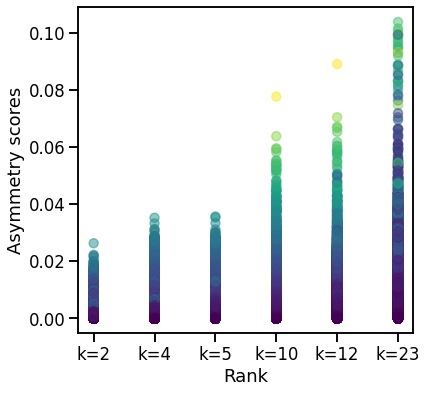

In [1209]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
for i, k in enumerate(ks):
    ax.scatter([i]*len(asym_scores[k]), asym_scores[k], c=asym_scores[10], alpha=0.5)
ax.set_ylabel("Asymmetry scores")
ax.set_xlabel("Rank")
ax.set_xticks(range(len(ks)))
ax.set_xticklabels(["k={}".format(k) for k in ks])
plt.show()

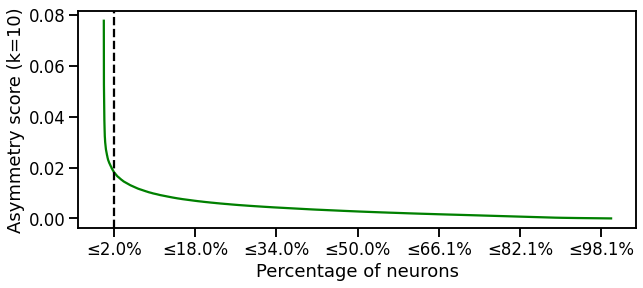

In [1231]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(np.sort(asym_scores[10])[::-1], c='g')
ax.axvline(1000, linestyle='--', color='k')
ax.set_xticks(np.arange(1000, wcc_g.num_vertices(), 8000))
ax.set_xticklabels(["≤{:.3}%".format(100*i) for i in (np.arange(1000, wcc_g.num_vertices(), 8000)+1)/wcc_g.num_vertices()])
ax.set_ylabel("Asymmetry score (k=10)")
ax.set_xlabel("Percentage of neurons")
plt.show()

In [1216]:
asym_nids = np.argsort(asym_scores[10])[::-1][:10]

In [1234]:
[np.arange(28)[np.array([(i in mod_vs[j]) for j in range(28)])].sum() for i in asym_nids]

[21, 1, 8, 23, 8, 25, 8, 16, 11, 12]

In [1235]:
[nid2cid[i] for i in asym_nids]

[720575940626028169,
 720575940624849610,
 720575940614503948,
 720575940630460044,
 720575940611101354,
 720575940622528951,
 720575940636133598,
 720575940622417845,
 720575940610781682,
 720575940635458734]

In [1233]:
vis_link([nid2cid[i] for i in asym_nids])

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_gra

### ... How does the 23-module structure look like?

In [1467]:
# trisect the brain via top 23 singularvectors
from sklearn.cluster import KMeans
normalize = lambda x: x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)

# note that some elements are zeros..

neu_rep_sig = np.nan_to_num(normalize(Lsigvec_l[:,:23]))
kmean = KMeans(n_clusters=23).fit(np.real(neu_rep_sig))
b23_receiving_groups = kmean.labels_

neu_rep_sig = np.nan_to_num(normalize(Lsigvec_r[:,:23]))
kmean = KMeans(n_clusters=23).fit(np.real(neu_rep_sig))
b23_sending_groups = kmean.labels_

In [1502]:
# with open("./saved/rb23_groups.data", 'wb') as f:
#     np.save(f, b23_receiving_groups)
    
# with open("./saved/sb23_groups.data", 'wb') as f:
#     np.save(f, b23_sending_groups)

In [1454]:
%%time
wcc_g_b23_receiving = block_graph(wcc_g, b23_receiving_groups)
wcc_g_b23_sending = block_graph(wcc_g, b23_sending_groups)

CPU times: user 4.86 s, sys: 144 ms, total: 5 s
Wall time: 3.72 s


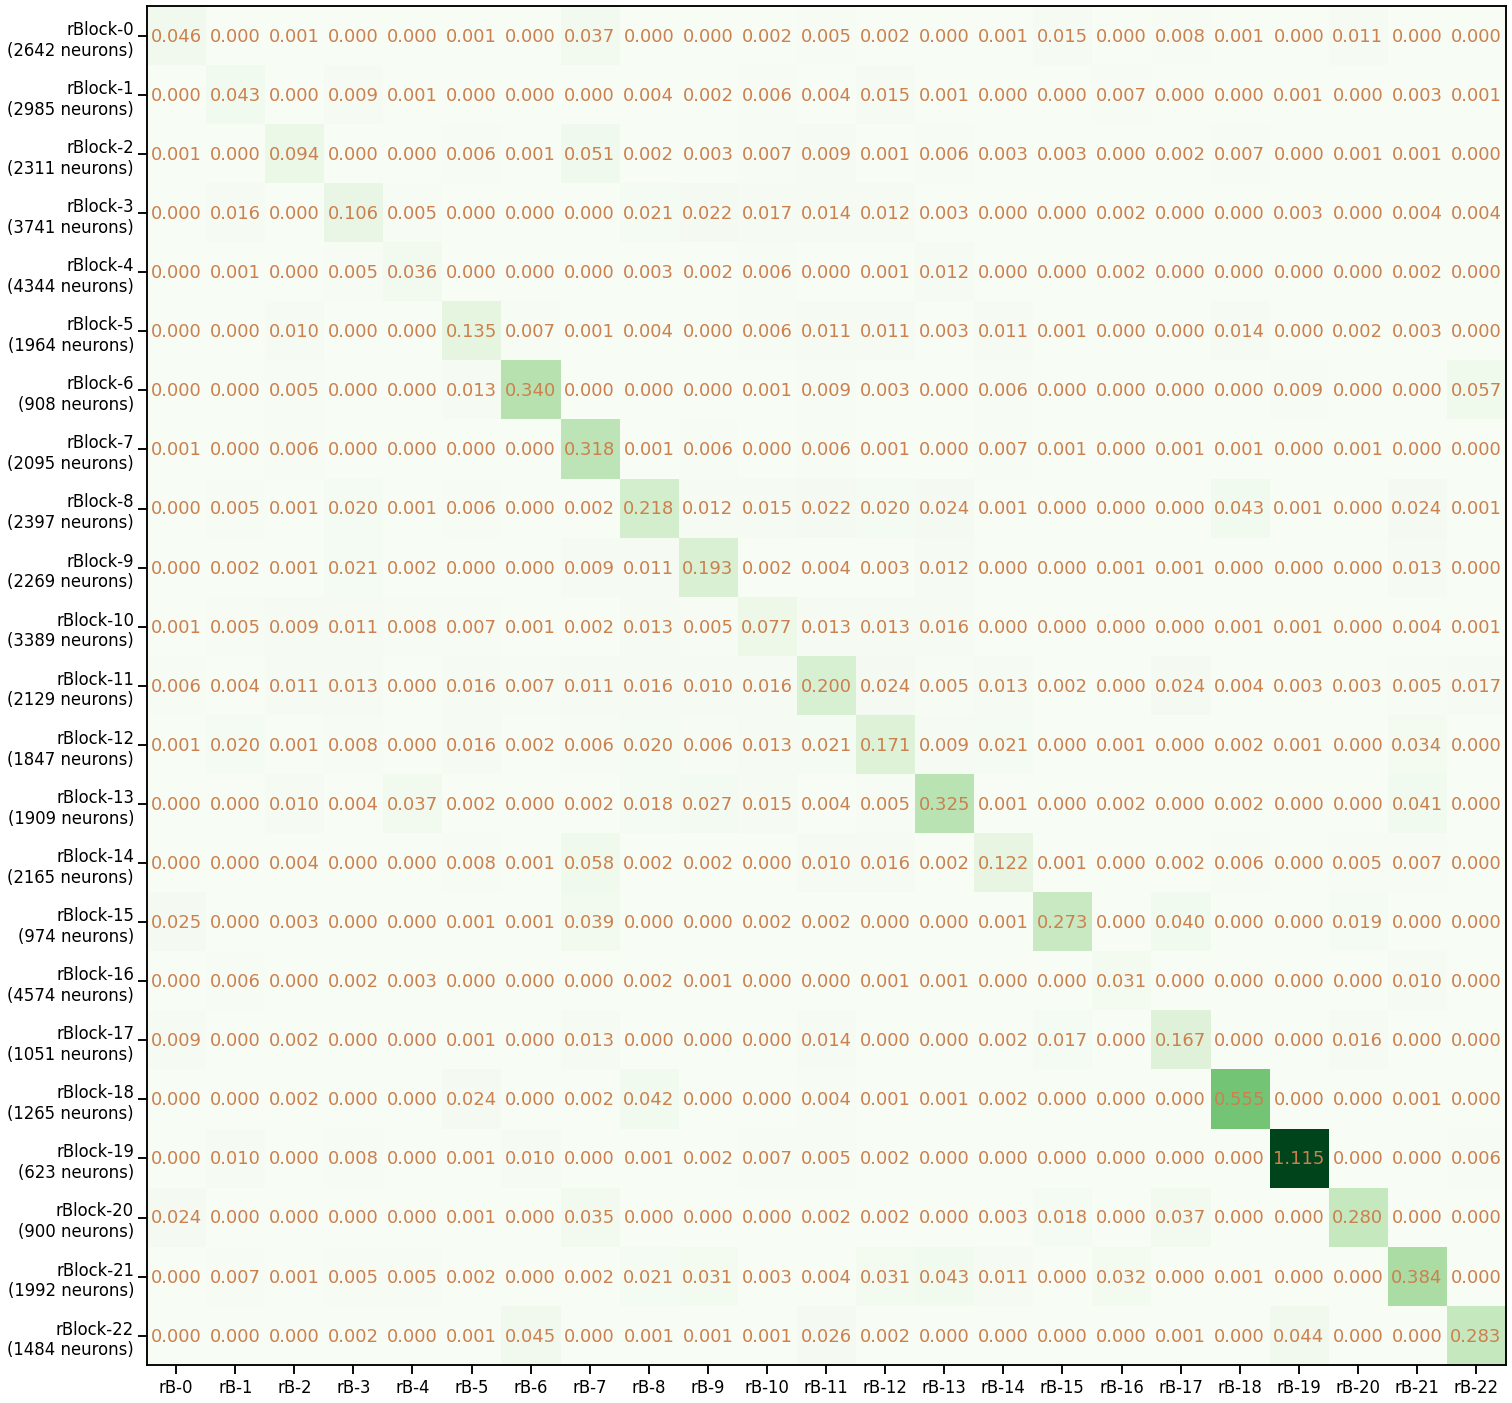

In [1458]:
rblock_sizes, rsyn_prob = summarize_block(wcc_g_b23_receiving, norm=True)

fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.imshow(rsyn_prob, 'Greens')
for i in range(23):
    for j in range(23):
        text = ax.text(j, i, "{:.3f}".format(rsyn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(23))
ax.set_xticklabels(["rB-{}".format(i) for i, s in enumerate(rblock_sizes)])
ax.set_yticks(range(23))
ax.set_yticklabels(["rBlock-{}\n({} neurons)".format(i, s) for i, s in enumerate(rblock_sizes)])
plt.show()

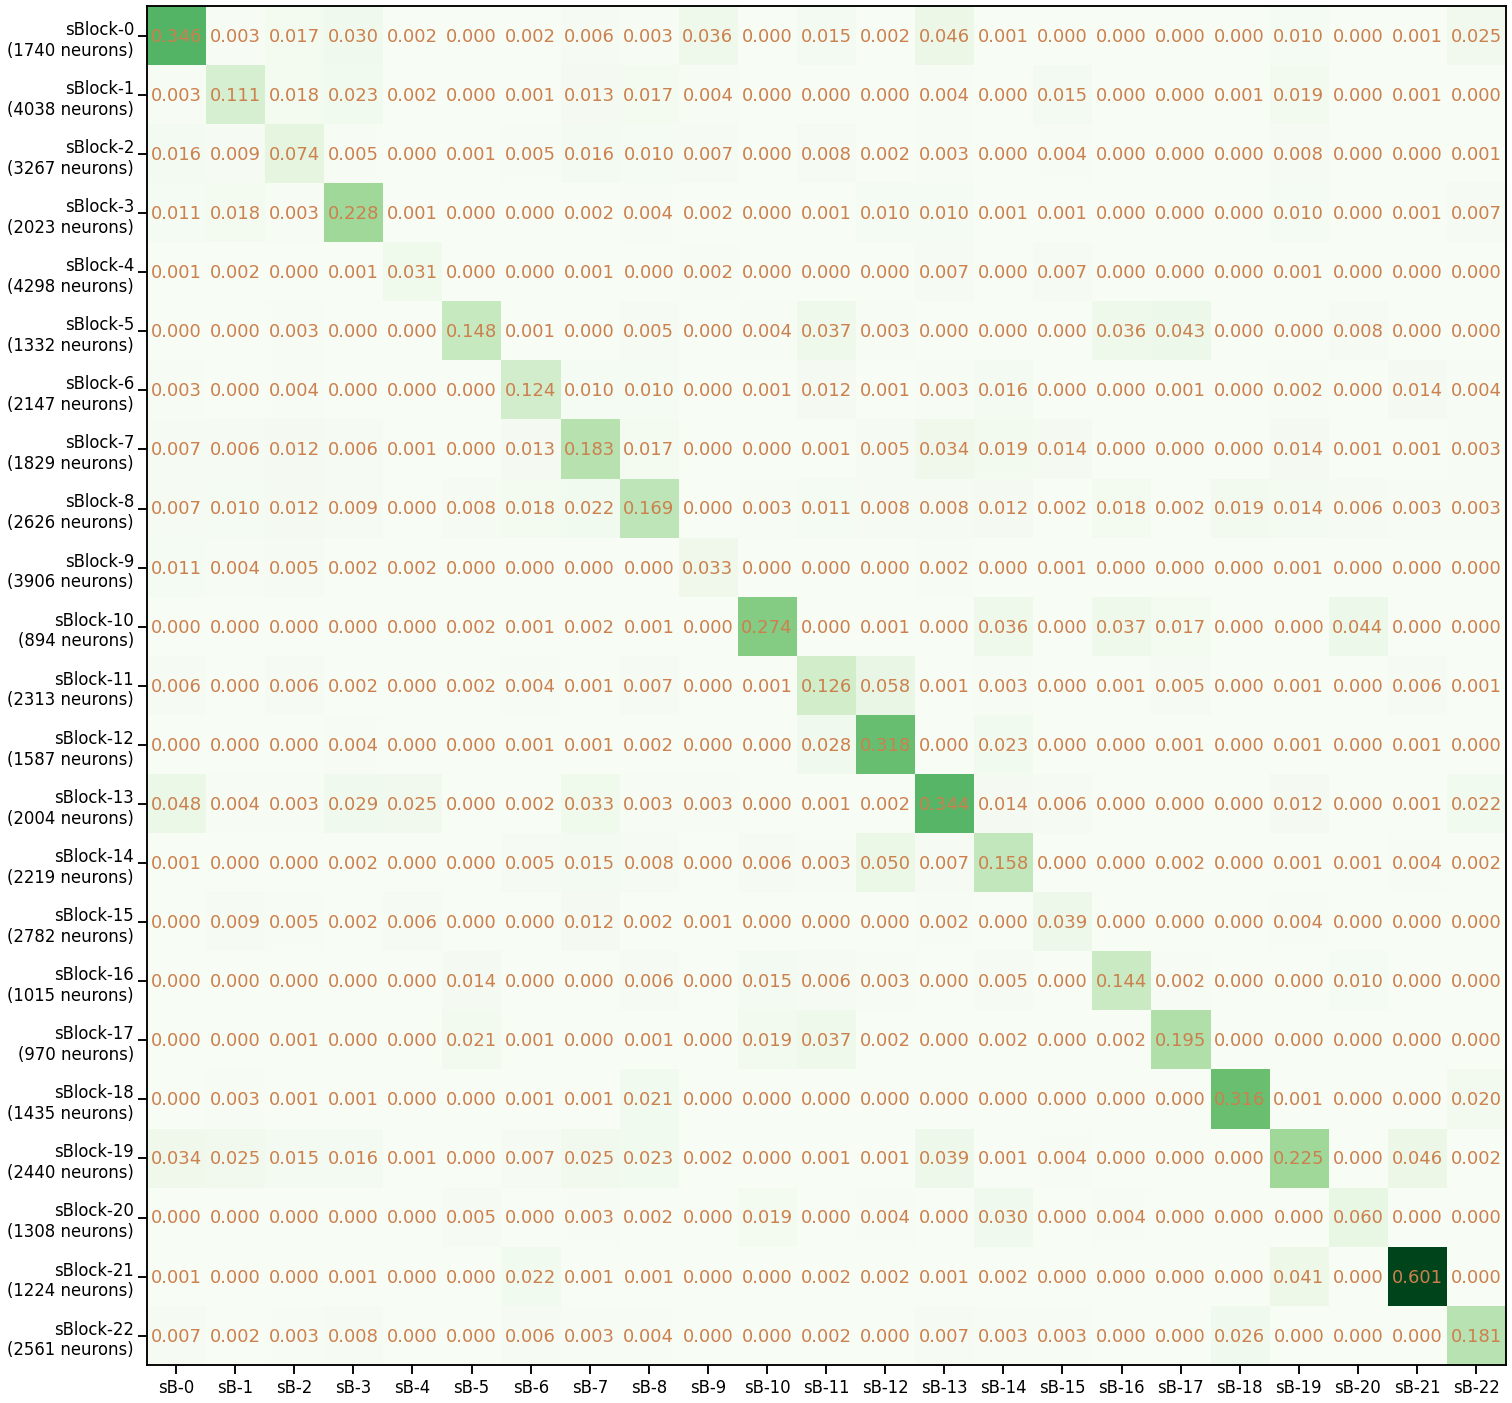

In [1459]:
sblock_sizes, ssyn_prob = summarize_block(wcc_g_b23_sending, norm=True)

fig, ax = plt.subplots(1,1,figsize=(25,25))
ax.imshow(ssyn_prob, 'Greens')
for i in range(23):
    for j in range(23):
        text = ax.text(j, i, "{:.3f}".format(ssyn_prob[i, j]),
                       ha="center", va="center", color=(0.8,0.5,0.3))
ax.set_xticks(range(23))
ax.set_xticklabels(["sB-{}".format(i) for i, s in enumerate(sblock_sizes)])
ax.set_yticks(range(23))
ax.set_yticklabels(["sBlock-{}\n({} neurons)".format(i, s) for i, s in enumerate(sblock_sizes)])
plt.show()

In [1464]:
rqy_cls = [b23_receiving_groups, b23_sending_groups]
total_num_block = 0
source, target, value = [], [], []

# recursive flatten
flatten = lambda a:[element for item in a for element in flatten(item)] if type(a) is list else [a]

label = flatten([["{}-{}".format(i,j) for j in range(23)] for i in ['rBlock', 'sBlock']])


stmp, ttmp, vtmp = get_stv(rqy_cls[0], rqy_cls[1] + 23)

source = source + stmp
target = target + ttmp
value = value + vtmp

In [1465]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)

In [1466]:
fig = go.Figure(data)
fig.write_html('figures/sankey-rqy-23-cls.html')
display(IFrame('figures/sankey-rqy-23-cls.html', width=900, height=600))

In [1471]:
rblock_ns = {b: wcc_g.get_vertices()[b23_receiving_groups==b] for b in range(23)}
sblock_ns = {b: wcc_g.get_vertices()[b23_sending_groups==b] for b in range(23)}

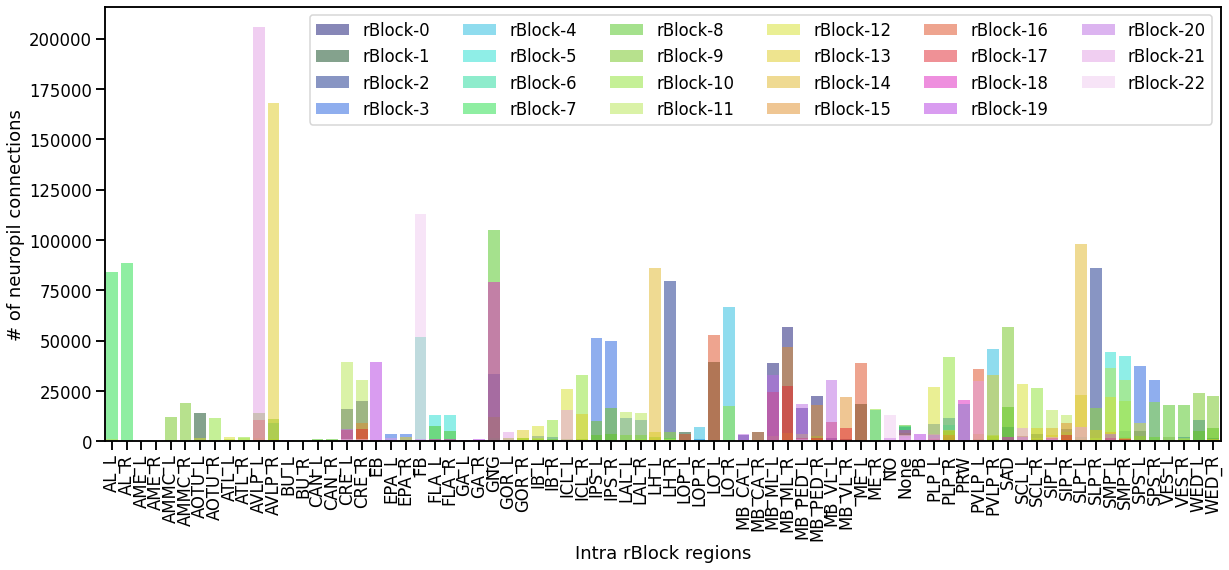

In [1476]:
reg_intra, reg_intra_cnt = {}, {}
colors = plt.cm.gist_ncar

for b in range(23):
    reg_intra[b], reg_intra_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(rblock_ns[b])
                                                             & syn_table["post_nid"].isin(rblock_ns[b])], 
                                       return_counts=True)
from functools import reduce
all_reg_intra = reduce(np.union1d, (reg_intra.values()))
intra_reg_dicts = [{k:reg_intra_cnt[b][i] for i, k in enumerate(reg_intra[b])} for b in range(23)]
for b in range(23):
    for reg in all_reg_intra:
        if reg not in intra_reg_dicts[b].keys():
            intra_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(23):
    sns.barplot(all_reg_intra, 
                list(intra_reg_dicts[b][reg] for reg in all_reg_intra), color=colors(b/23), alpha=0.5, label='rBlock-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra rBlock regions")
ax.legend(ncol=6)
plt.show()

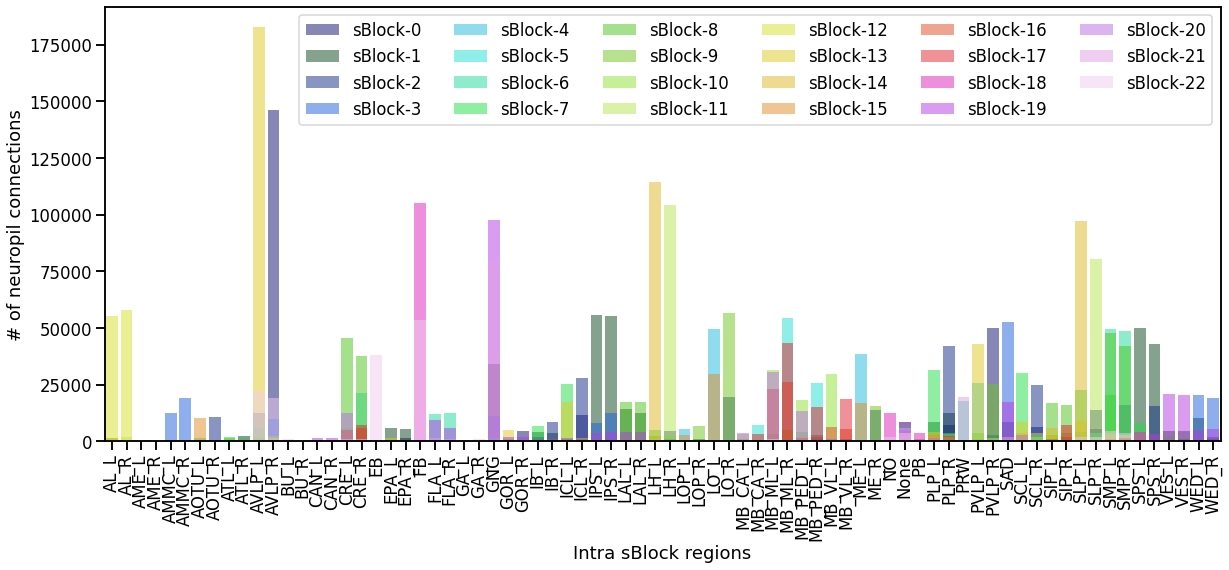

In [1477]:
reg_intra, reg_intra_cnt = {}, {}
colors = plt.cm.gist_ncar

for b in range(23):
    reg_intra[b], reg_intra_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(sblock_ns[b])
                                                             & syn_table["post_nid"].isin(sblock_ns[b])], 
                                       return_counts=True)
from functools import reduce
all_reg_intra = reduce(np.union1d, (reg_intra.values()))
intra_reg_dicts = [{k:reg_intra_cnt[b][i] for i, k in enumerate(reg_intra[b])} for b in range(23)]
for b in range(23):
    for reg in all_reg_intra:
        if reg not in intra_reg_dicts[b].keys():
            intra_reg_dicts[b][reg] = 0
            
fig, ax = plt.subplots(1,1,figsize=(20,8))
for b in range(23):
    sns.barplot(all_reg_intra, 
                list(intra_reg_dicts[b][reg] for reg in all_reg_intra), 
                color=colors(b/23), alpha=0.5, label='sBlock-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra sBlock regions")
ax.legend(ncol=6)
plt.show()

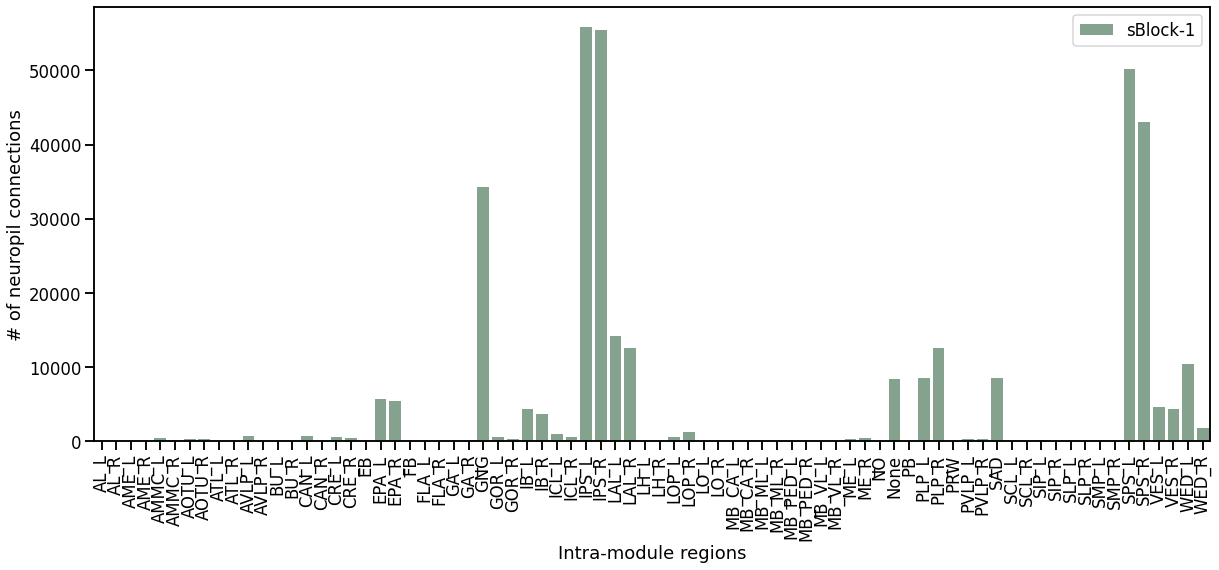

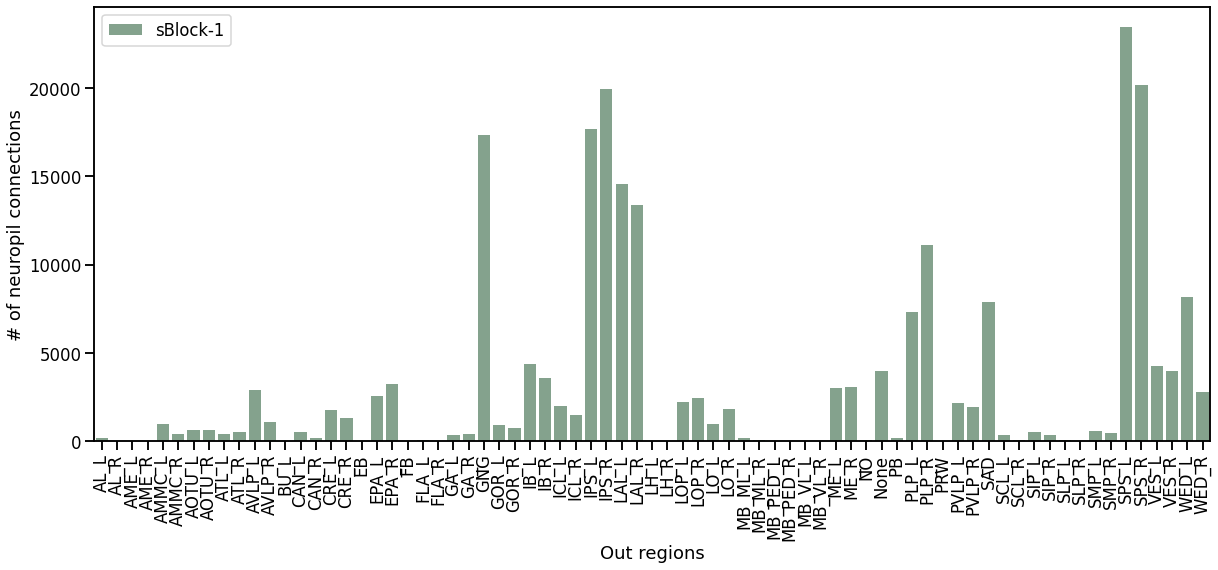

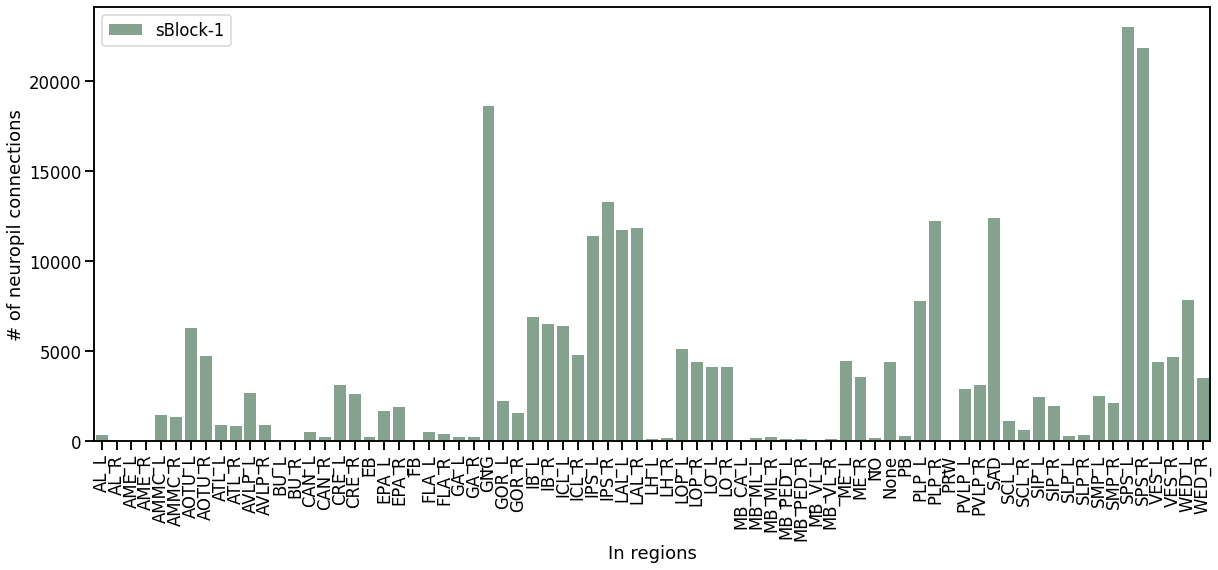

In [1635]:
b = 1
fig, ax = plt.subplots(1,1,figsize=(20,8))
sns.barplot(all_reg_intra, list(intra_reg_dicts[b][reg] for reg in all_reg_intra), color=colors(b/23), 
            alpha=0.5, label='sBlock-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Intra-module regions")
ax.legend(ncol=6)
plt.show()

mod_vs_reg_out[b], mod_vs_reg_out_cnt[b] = np.unique(syn_table["neuropil"][syn_table["pre_nid"].isin(sblock_ns[b])
                                                             & ~syn_table["post_nid"].isin(sblock_ns[b])], 
                                       return_counts=True)
fig, ax = plt.subplots(1,1,figsize=(20,8))
sns.barplot(mod_vs_reg_out[b], mod_vs_reg_out_cnt[b], color=colors(b/23), 
            alpha=0.5, label='sBlock-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("Out regions")
ax.legend(ncol=6)
plt.show()

mod_vs_reg_in[b], mod_vs_reg_out_in[b] = np.unique(syn_table["neuropil"][~syn_table["pre_nid"].isin(sblock_ns[b])
                                                             & syn_table["post_nid"].isin(sblock_ns[b])], 
                                       return_counts=True)
fig, ax = plt.subplots(1,1,figsize=(20,8))
sns.barplot(mod_vs_reg_in[b], mod_vs_reg_out_in[b], color=colors(b/23), 
            alpha=0.5, label='sBlock-{}'.format(b))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("# of neuropil connections")
ax.set_xlabel("In regions")
ax.legend(ncol=6)
plt.show()

# # visualize 100 neurons in mod xxx
# vis_link(np.random.choice([nid2cid[i] for i in sblock_ns[b]], 200, replace=False))

In [1532]:
sblock_g = wcc_g_b23_sending.get_bg().copy()

In [1533]:
node_size = sblock_g.new_vertex_property("int32_t")
for v in sblock_g.vertices():
    node_size[v] = wcc_g_b23_sending.get_nr()[v]
sblock_g.vp["size"] = node_size

In [1534]:
node_density = sblock_g.new_vertex_property("float")
for i, v in enumerate(sblock_g.vertices()):
    node_density[v] = ssyn_prob[i,i]
sblock_g.vp["density"] = node_density

In [1613]:
p_syn = sblock_g.new_edge_property("float")
for e in sblock_g.edges():
    if e.source() == e.target():
        # remove self-loops
        p_syn[e] == 0
    else:
        p_syn[e] = wcc_g_b23_sending.get_ers()[e] / (wcc_g_b23_sending.get_nr()[e.target()] 
                                             * wcc_g_b23_sending.get_nr()[e.source()])
sblock_g.ep["syn_prob"] = p_syn

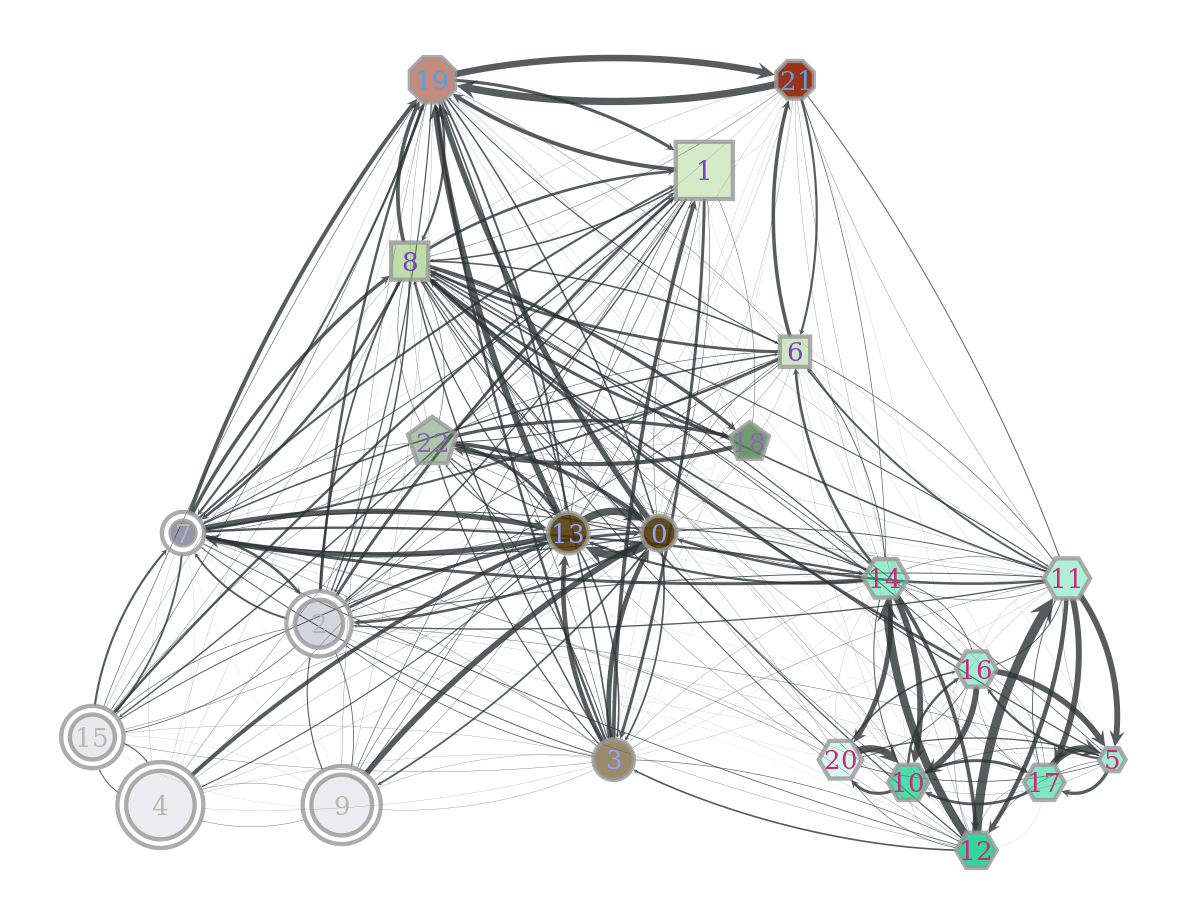

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd3b0249d68, at 0x7fd393e50a90>

In [1620]:
vlabel = sblock_g.new_vertex_property("int32_t")
vlabel.a = np.arange(23)
vsize = sblock_g.new_vertex_property("float")
vsize.a = sblock_g.vp["size"].a / 100

esyn_th = 0.00
ewith = sblock_g.new_edge_property("float")
ewith.a = sblock_g.ep["syn_prob"].a
ewith.a[ewith.a < esyn_th] = 0.0
ewith.a = ewith.a * 80

pos_dict = {
    ## central complex:
    18: (3, 0),
    22: (-4, 0),
    ## olfactory:
    12: (8,9),
    20: (5,7), 10: (6.5,7.5), 16: (8,5), 17: (9.5,7.5), 5: (11,7),
    14: (6,3), 11: (10,3),
    ## auditory:
    0:(1,2),13:(-1,2),
    3:(0,7),
    ## visual:
    7:(-9.5,2),2:(-6.5,4),
    4:(-10,8),9:(-6,8),15:(-11.5,6.5),
    ## integration:
    6:(4,-2),
    8:(-4.5,-4),
    1:(2,-6),
    ## sensory, motor:
    19:(-4,-8),
    21:(4,-8)
}

shape_dict = {
    ## central complex:
    18: 3,
    22: 3,
    ## olfactory:
    12: 4,
    20: 4, 10: 4, 16: 4, 17: 4, 5: 4,
    14: 4, 11: 4,
    ## auditory:
    0:0,13:0,
    3:0,
    ## visual:
    7:7,2:7,
    4:7,9:7,15:7,
    ## integration:
    6:2,
    8:2,
    1:2,
    ## sensory, motor:
    19:6,
    21:6
}

color_dict = {
    ## central complex:
    18: [0.3,0.5,0.3,0.8],
    22: [0.3,0.5,0.3,0.8],
    ## olfactory:
    12: [0.0, 0.8, 0.5,0.8],
    20: [0.0, 0.8, 0.5,0.8], 10: [0.0, 0.8, 0.5,0.8], 
    16: [0.0, 0.8, 0.5,0.8], 17: [0.0, 0.8, 0.5,0.8], 5: [0.0, 0.8, 0.5,0.8],
    14: [0.0, 0.8, 0.5,0.8], 11: [0.0, 0.8, 0.5,0.8],
    ## auditory:
    0:[0.3,0.2,0,0.8],13:[0.3,0.2,0,0.8],
    3:[0.3,0.2,0,0.8],
    ## visual:
    7:[0.1,0.1,0.3,0.8],2:[0.1,0.1,0.3,0.8],
    4:[0.1,0.1,0.3,0.8],9:[0.1,0.1,0.3,0.8],15:[0.1,0.1,0.3,0.8],
    ## integration:
    6:[0.4,0.7,0.2,0.8],
    8:[0.4,0.7,0.2,0.8],
    1:[0.4,0.7,0.2,0.8],
    ## sensory, motor:
    19:[0.6,0.2,0.1,0.8],
    21:[0.6,0.2,0.1,0.8]
}

color_density_dict = {k:[color_dict[k][0], color_dict[k][1], 
                       color_dict[k][2], ssyn_prob[k,k] * 2.5] for k in color_dict.keys()}

pos = sblock_g.new_vertex_property("vector<double>")
for i, v in enumerate(sblock_g.vertices()):
    pos[v] = pos_dict[i]
    
vshape = sblock_g.new_vertex_property("int32_t")
for i, v in enumerate(sblock_g.vertices()):
    vshape[v] = shape_dict[i]
    
vcolor = sblock_g.new_vertex_property("vector<double>")
for i, v in enumerate(sblock_g.vertices()):
    vcolor[v] = color_density_dict[i]
    
vtxtcolor = sblock_g.new_vertex_property("vector<double>")
for i, v in enumerate(sblock_g.vertices()):
    vtxtcolor[v] = [color_dict[i][3]*(1-color_dict[i][0]), 
                    color_dict[i][3]*(1-color_dict[i][1]), 
                    (1-color_dict[i][2]), 1]
    
    
gt.graph_draw(sblock_g, pos=pos, vertex_shape=vshape, vertex_text=vlabel, vertex_text_color=vtxtcolor, 
              vertex_fill_color=vcolor, vertex_size=vsize, edge_pen_width=ewith)